In [2]:
import os 
import matplotlib
import pandas  as pd 
import numpy as np
import seaborn as sns 

In [3]:
country_military_spending = pd.read_csv('military_spending_constant_2023.csv', sep = ',',    skiprows=5)
country_military_spending_2024 = country_military_spending[['Country','2024']]
country_military_spending_2024
us_spend = country_military_spending_2024[country_military_spending_2024['Country'] == 'United States of America'].copy()
other_countries_spend = country_military_spending_2024[country_military_spending_2024['Country'] != 'United States of America'].copy()
other_countries_spend = other_countries_spend.dropna()
other_countries_spend = other_countries_spend[other_countries_spend['2024'] != 'xxx']
other_countries_spend = other_countries_spend[other_countries_spend['2024'] != '...']
other_countries_spend['2024'] = np.array(other_countries_spend['2024'], dtype=float)
### Change US Spend to Billions


In [36]:
import pandas as pd
import numpy as np

# --- Inputs / lists -----------------------------------------------------------
nato_countries = [
    "United States of America", "Canada", "United Kingdom", "France", "Germany",
    "Italy", "Spain", "Portugal", "Greece", "Türkiye", "Belgium", "Netherlands",
    "Luxembourg", "Norway", "Denmark", "Iceland", "Poland", "Czechia",
    "Hungary", "Slovakia", "Slovenia", "Romania", "Bulgaria", "Estonia",
    "Finland", "Sweden", "Latvia", "Lithuania", "Croatia", "Albania",
    "Montenegro", "North Macedonia"
]

european_nato = [c for c in nato_countries if c not in ["United States of America", "Canada"]]

CSV_PATH = "military_spending_constant_2023.csv"  # adjust if needed
YEARS = ["2022", "2024"]  # columns we’ll compare

# --- Load & clean -------------------------------------------------------------
df = pd.read_csv(CSV_PATH, sep=",", skiprows=5)

# Keep only needed cols
must_have = ["Country"] + YEARS
df = df[must_have].copy()

# Drop non-data markers and NaNs
for y in YEARS:
    df = df[(df[y].notna()) & (~df[y].isin(["xxx", "..."]))]

# Convert to numeric
for y in YEARS:
    df[y] = pd.to_numeric(df[y], errors="coerce")
df = df.dropna(subset=YEARS)

# --- Helper to find China robustly -------------------------------------------
def get_china_row(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Try common exact names first
    exact_candidates = [
        "China",
        "People's Republic of China",
        "China, mainland",
        "China (mainland)"
    ]
    for name in exact_candidates:
        hit = dataframe.loc[dataframe["Country"].str.strip().eq(name)]
        if not hit.empty:
            return hit.iloc[[0]]

    # Fallback: strict regex for "China" alone or with "(mainland)" / leading "People's Republic of"
    hit = dataframe.loc[
        dataframe["Country"].str.strip().str.match(
            r"^(China|China, mainland|China \(mainland\)|People'?s Republic of China)$",
            case=False, na=False
        )
    ]
    if not hit.empty:
        return hit.iloc[[0]]

    raise ValueError("Could not locate China in the dataset. Check the 'Country' naming.")

# --- Slice: European NATO vs China -------------------------------------------
df_nato_eur = df[df["Country"].isin(european_nato)].copy()
missing_nato = sorted(set(european_nato) - set(df_nato_eur["Country"]))

china = get_china_row(df)

# Totals
nato_totals = df_nato_eur[YEARS].sum()
china_totals = china[YEARS].iloc[0]

# --- Comparison table ---------------------------------------------------------
out = pd.DataFrame({
    "Group": ["European NATO (ex-US/Canada)", "China"],
    YEARS[0]: [nato_totals[YEARS[0]], china_totals[YEARS[0]]],
    YEARS[1]: [nato_totals[YEARS[1]], china_totals[YEARS[1]]],
})

# Absolute and % change for each group
out["Abs_Change"] = out[YEARS[1]] - out[YEARS[0]]
out["Pct_Change"] = (out["Abs_Change"] / out[YEARS[0]]) * 100

# Difference & ratio (European NATO vs China)
diff_2022 = nato_totals[YEARS[0]] - china_totals[YEARS[0]]
diff_2024 = nato_totals[YEARS[1]] - china_totals[YEARS[1]]
ratio_2022 = nato_totals[YEARS[0]] / china_totals[YEARS[0]]
ratio_2024 = nato_totals[YEARS[1]] / china_totals[YEARS[1]]

# --- Output -------------------------------------------------------------------
pd.set_option("display.float_format", lambda v: f"{v:,.2f}")

print("\n=== European NATO (excluding U.S. & Canada) vs China ===")
print(f"Units are whatever units the CSV provides (e.g., constant 2023 USD).")
print("\nTotals and changes:")
print(out.to_string(index=False))

print("\nHead-to-head comparison (European NATO minus China):")
print(f" {YEARS[0]}: difference = {diff_2022:,.2f} | ratio (NATO/China) = {ratio_2022:,.3f}")
print(f" {YEARS[1]}: difference = {diff_2024:,.2f} | ratio (NATO/China) = {ratio_2024:,.3f}")

if missing_nato:
    print("\nNOTE: The following NATO countries were not found in the dataset:")
    for c in missing_nato:
        print(f" - {c}")



=== European NATO (excluding U.S. & Canada) vs China ===
Units are whatever units the CSV provides (e.g., constant 2023 USD).

Totals and changes:
                       Group       2022       2024  Abs_Change  Pct_Change
European NATO (ex-US/Canada) 370,407.90 460,400.30   89,992.40       24.30
                       China 278,474.40 317,561.00   39,086.60       14.04

Head-to-head comparison (European NATO minus China):
 2022: difference = 91,933.50 | ratio (NATO/China) = 1.330
 2024: difference = 142,839.30 | ratio (NATO/China) = 1.450


In [95]:
import pandas as pd
import numpy as np
from typing import Optional

# --- Inputs / lists -----------------------------------------------------------
nato_countries = [
    "United States of America", "Canada", "United Kingdom", "France", "Germany",
    "Italy", "Spain", "Portugal", "Greece", "Türkiye", "Belgium", "Netherlands",
    "Luxembourg", "Norway", "Denmark", "Iceland", "Poland", "Czechia",
    "Hungary", "Slovakia", "Slovenia", "Romania", "Bulgaria", "Estonia",
    "Finland", "Sweden", "Latvia", "Lithuania", "Croatia", "Albania",
    "Montenegro", "North Macedonia"
]

# Only European NATO members (exclude U.S. & Canada)
european_nato = [c for c in nato_countries if c not in ["United States of America", "Canada"]]

CSV_PATH = "military_spending_constant_2023.csv"  # adjust if needed
YEARS = ["2022", "2024"]  # columns to compare

# --- Load & clean -------------------------------------------------------------
df = pd.read_csv(CSV_PATH, sep=",", skiprows=5)

# Keep only needed columns
must_have = ["Country"] + YEARS
df = df[must_have].copy()

# Remove non-data markers and NaNs
for y in YEARS:
    df = df[(df[y].notna()) & (~df[y].isin(["xxx", "..."]))]

# Convert to numeric
for y in YEARS:
    df[y] = pd.to_numeric(df[y], errors="coerce")
df = df.dropna(subset=YEARS)

# --- Helper to locate a country robustly -------------------------------------
def get_country_row(dataframe: pd.DataFrame, aliases: list, pattern: Optional[str] = None) -> pd.DataFrame:
    # Try exact aliases first
    for name in aliases:
        hit = dataframe.loc[dataframe["Country"].str.strip().eq(name)]
        if not hit.empty:
            return hit.iloc[[0]]
    # Optional regex fallback
    if pattern:
        hit = dataframe.loc[dataframe["Country"].str.strip().str.match(pattern, case=False, na=False)]
        if not hit.empty:
            return hit.iloc[[0]]
    raise ValueError(f"Could not locate country using aliases={aliases}")

# --- Slice: European NATO vs Russia ------------------------------------------
df_nato_eur = df[df["Country"].isin(european_nato)].copy()
missing_nato = sorted(set(european_nato) - set(df_nato_eur["Country"]))

# Common Russia namings in datasets
russia_aliases = [
    "Russia",
    "Russian Federation",
    "Russia (Federation)"
]
russia_pattern = r"^(Russia|Russian Federation|Russia \(Federation\))$"

russia = get_country_row(df, russia_aliases, russia_pattern)

# Totals
nato_totals = df_nato_eur[YEARS].sum()
russia_totals = russia[YEARS].iloc[0]

# --- Comparison table ---------------------------------------------------------
out = pd.DataFrame({
    "Group": ["European NATO (ex-US/Canada)", "Russia"],
    YEARS[0]: [nato_totals[YEARS[0]], russia_totals[YEARS[0]]],
    YEARS[1]: [nato_totals[YEARS[1]], russia_totals[YEARS[1]]],
})

# Absolute and % change for each group
out["Abs_Change"] = out[YEARS[1]] - out[YEARS[0]]
out["Pct_Change"] = (out["Abs_Change"] / out[YEARS[0]]) * 100

# Head-to-head difference & ratio (European NATO vs Russia)
diff_2022 = nato_totals[YEARS[0]] - russia_totals[YEARS[0]]
diff_2024 = nato_totals[YEARS[1]] - russia_totals[YEARS[1]]
ratio_2022 = nato_totals[YEARS[0]] / russia_totals[YEARS[0]]
ratio_2024 = nato_totals[YEARS[1]] / russia_totals[YEARS[1]] if russia_totals[YEARS[1]] != 0 else float("inf")

# --- Output -------------------------------------------------------------------
pd.set_option("display.float_format", lambda v: f"{v:,.2f}")

print("\n=== European NATO (excluding U.S. & Canada) vs Russia ===")
print("Units are whatever units the CSV provides (e.g., constant 2023 USD).")
print("\nTotals and changes:")
print(out.to_string(index=False))

print("\nHead-to-head comparison (European NATO minus Russia):")
print(f" {YEARS[0]}: difference = {diff_2022:,.2f} | ratio (NATO/Russia) = {ratio_2022:,.3f}")
print(f" {YEARS[1]}: difference = {diff_2024:,.2f} | ratio (NATO/Russia) = {ratio_2024:,.3f}")

if missing_nato:
    print("\nNOTE: The following NATO countries were not found in the dataset:")
    for c in missing_nato:
        print(f" - {c}")



=== European NATO (excluding U.S. & Canada) vs Russia ===
Units are whatever units the CSV provides (e.g., constant 2023 USD).

Totals and changes:
                       Group       2022       2024  Abs_Change  Pct_Change
European NATO (ex-US/Canada) 370,407.90 460,400.30   89,992.40       24.30
                      Russia  88,877.40 150,534.00   61,656.60       69.37

Head-to-head comparison (European NATO minus Russia):
 2022: difference = 281,530.50 | ratio (NATO/Russia) = 4.168
 2024: difference = 309,866.30 | ratio (NATO/Russia) = 3.058


In [91]:
import pandas as pd
import numpy as np

nato_countries = [
    "United States of America", "Canada", "United Kingdom", "France", "Germany",
    "Italy", "Spain", "Portugal", "Greece", "Türkiye", "Belgium", "Netherlands",
    "Luxembourg", "Norway", "Denmark", "Iceland", "Poland", "Czechia",
    "Hungary", "Slovakia", "Slovenia", "Romania", "Bulgaria", "Estonia",
    "Finland", "Sweden", "Latvia", "Lithuania", "Croatia", "Albania",
    "Montenegro", "North Macedonia"
]

print(len(nato_countries))

# Load data
country_military_spending = pd.read_csv(
    'military_spending_constant_2023.csv',
    sep=',',
    skiprows=5
)

# Keep only relevant columns (2022 & 2024)
df = country_military_spending[['Country', '2022', '2024']].copy()

# Drop missing/invalid values
df = df.dropna()
df = df[(df['2022'] != 'xxx') & (df['2022'] != '...')]
df = df[(df['2024'] != 'xxx') & (df['2024'] != '...')]

# Convert to numeric
df['2022'] = pd.to_numeric(df['2022'], errors='coerce')
df['2024'] = pd.to_numeric(df['2024'], errors='coerce')

# Drop rows with NaN after conversion
df = df.dropna()

# Filter only NATO countries
df_nato = df[df['Country'].isin(nato_countries)].copy()

# Calculate percentage increase
df_nato['pct_increase'] = ((df_nato['2024'] - df_nato['2022']) / df_nato['2022']) * 100

# Sort by largest increase
df_nato_sorted = df_nato.sort_values(by='pct_increase', ascending=False)

# Show top NATO countries by % increase
print(df_nato_sorted[['Country', '2022', '2024', 'pct_increase']].head(10))


32
         Country      2022      2024  pct_increase
139       Poland 18,057.20 34,488.30         90.99
125      Albania    267.50    481.50         80.00
158      Denmark  5,801.20  9,781.60         68.61
166   Luxembourg    543.40    849.40         56.31
168  Netherlands 14,540.70 22,439.20         54.32
131      Estonia    917.50  1,392.70         51.79
172       Sweden  7,963.00 11,718.50         47.16
135       Latvia    958.10  1,404.80         46.62
129      Czechia  4,668.00  6,676.00         43.02
159      Finland  4,852.80  6,893.90         42.06


In [59]:
import pandas as pd
import numpy as np

# Load and clean data
df = pd.read_csv('military_spending_constant_2023.csv', sep=',', skiprows=5)
df = df[['Country', '2022', '2024']].copy()
df = df.dropna()
df = df[(df['2022'] != 'xxx') & (df['2022'] != '...')]
df = df[(df['2024'] != 'xxx') & (df['2024'] != '...')]
df['2022'] = pd.to_numeric(df['2022'], errors='coerce')
df['2024'] = pd.to_numeric(df['2024'], errors='coerce')
df = df.dropna()

# NATO members
nato_countries = [
    "United States of America", "Canada", "United Kingdom", "France", "Germany",
    "Italy", "Spain", "Portugal", "Greece", "Türkiye", "Belgium", "Netherlands",
    "Luxembourg", "Norway", "Denmark", "Iceland", "Poland", "Czechia",
    "Hungary", "Slovakia", "Slovenia", "Romania", "Bulgaria", "Estonia",
    "Finland", "Sweden", "Latvia", "Lithuania", "Croatia", "Albania",
    "Montenegro", "North Macedonia"
]


# Split data into NATO and non-NATO
df['is_nato'] = df['Country'].isin(nato_countries)

# Sum 2022 and 2024 spending
world_2022 = df['2022'].sum()
world_2024 = df['2024'].sum()
world_increase = world_2024 - world_2022

nato_2022 = df.loc[df['is_nato'], '2022'].sum()
nato_2024 = df.loc[df['is_nato'], '2024'].sum()
nato_increase = nato_2024 - nato_2022

# Compute percentage of worldwide increase due to NATO countries
nato_share = (nato_increase / world_increase) * 100

print(f"Worldwide military spending increase (2022→2024): {world_increase:,.1f}")
print(f"NATO increase (2022→2024): {nato_increase:,.1f}")
print(f"NATO accounted for {nato_share:.1f}% of the global increase.")

Worldwide military spending increase (2022→2024): 364,183.3
NATO increase (2022→2024): 165,720.7
NATO accounted for 45.5% of the global increase.


In [94]:
import pandas as pd
import numpy as np

# --- Load and clean ---
df = pd.read_csv('military_spending_constant_2023.csv', sep=',', skiprows=5)
df = df[['Country', '2022', '2024']].copy()
df = df.dropna()
df = df[(df['2022'] != 'xxx') & (df['2022'] != '...')]
df = df[(df['2024'] != 'xxx') & (df['2024'] != '...')]
df['2022'] = pd.to_numeric(df['2022'], errors='coerce')
df['2024'] = pd.to_numeric(df['2024'], errors='coerce')
df = df.dropna()

# --- NATO members ---
nato_countries = [
    "United States of America", "Canada", "United Kingdom", "France", "Germany",
    "Italy", "Spain", "Portugal", "Greece", "Türkiye", "Belgium", "Netherlands",
    "Luxembourg", "Norway", "Denmark", "Iceland", "Poland", "Czechia",
    "Hungary", "Slovakia", "Slovenia", "Romania", "Bulgaria", "Estonia",
    "Finland", "Sweden", "Latvia", "Lithuania", "Croatia", "Albania",
    "Montenegro", "North Macedonia"
]
print(len(nato_countries))
df['is_nato'] = df['Country'].isin(nato_countries)

# --- Define European NATO countries (exclude US + Canada) ---
european_nato = [c for c in nato_countries if c not in ["United States of America", "Canada"]]
df['is_euro_nato'] = df['Country'].isin(european_nato)

# --- Calculate increases ---
nato_2022 = df.loc[df['is_nato'], '2022'].sum()
nato_2024 = df.loc[df['is_nato'], '2024'].sum()
nato_increase = nato_2024 - nato_2022

euro_2022 = df.loc[df['is_euro_nato'], '2022'].sum()
euro_2024 = df.loc[df['is_euro_nato'], '2024'].sum()
euro_increase = euro_2024 - euro_2022

# --- Compute share of NATO’s increase driven by Europe ---
share_europe_of_nato_increase = (euro_increase / nato_increase) * 100

print(f"Total NATO increase (2022→2024): {nato_increase:,.1f}")
print(f"European NATO increase (excluding US & Canada): {euro_increase:,.1f}")
print(f"European NATO countries drove {share_europe_of_nato_increase:.1f}% of the total NATO spending increase.")


32
Total NATO increase (2022→2024): 165,720.7
European NATO increase (excluding US & Canada): 89,992.4
European NATO countries drove 54.3% of the total NATO spending increase.


In [96]:
import pandas as pd
import numpy as np

# Load and clean data
df = pd.read_csv('military_spending_constant_2023.csv', sep=',', skiprows=5)
df = df[['Country', '2022', '2024']].copy()
df = df.dropna()
df = df[(df['2022'] != 'xxx') & (df['2022'] != '...')]
df = df[(df['2024'] != 'xxx') & (df['2024'] != '...')]
df['2022'] = pd.to_numeric(df['2022'], errors='coerce')
df['2024'] = pd.to_numeric(df['2024'], errors='coerce')
df = df.dropna()

# NATO member list
nato_countries = [
    "United States of America", "Canada", "United Kingdom", "France", "Germany",
    "Italy", "Spain", "Portugal", "Greece", "Türkiye", "Belgium", "Netherlands",
    "Luxembourg", "Norway", "Denmark", "Iceland", "Poland", "Czechia",
    "Hungary", "Slovakia", "Slovenia", "Romania", "Bulgaria", "Estonia",
    "Finland", "Sweden", "Latvia", "Lithuania", "Croatia", "Albania",
    "Montenegro", "North Macedonia"
]


# Mark NATO countries
df['is_nato'] = df['Country'].isin(nato_countries)

# --- Compute 2024 totals ---
world_2024 = df['2024'].sum()
nato_2024 = df.loc[df['is_nato'], '2024'].sum()

# --- Compute NATO's share ---
nato_share_2024 = (nato_2024 / world_2024) * 100

print(f"Worldwide military spending in 2024: {world_2024:,.1f}")
print(f"NATO military spending in 2024: {nato_2024:,.1f}")
print(f"NATO countries accounted for {nato_share_2024:.1f}% of global military spending in 2024.")


Worldwide military spending in 2024: 2,601,955.8
NATO military spending in 2024: 1,457,847.8
NATO countries accounted for 56.0% of global military spending in 2024.


In [28]:
import pandas as pd
import numpy as np

# --- Load and clean ---
df = pd.read_csv('military_spending_constant_2023.csv', sep=',', skiprows=5)
df = df[['Country', '2022', '2024']].copy()
df = df.dropna()
df = df[(df['2022'] != 'xxx') & (df['2022'] != '...')]
df = df[(df['2024'] != 'xxx') & (df['2024'] != '...')]
df['2022'] = pd.to_numeric(df['2022'], errors='coerce')
df['2024'] = pd.to_numeric(df['2024'], errors='coerce')
df = df.dropna()

# --- Compute totals ---
world_2024 = df['2024'].sum()

# --- Extract China's 2024 spending ---
china_2024 = df.loc[df['Country'] == 'China', '2024'].sum()

# --- Compute China's share ---
china_share_2024 = (china_2024 / world_2024) * 100

print(f"Worldwide military spending in 2024: {world_2024:,.1f}")
print(f"China's military spending in 2024: {china_2024:,.1f}")
print(f"China accounted for {china_share_2024:.1f}% of total global military spending in 2024.")


Worldwide military spending in 2024: 2,601,955.8
China's military spending in 2024: 317,561.0
China accounted for 12.2% of total global military spending in 2024.


In [62]:
import pandas as pd
import numpy as np

# --- Load and clean ---
df = pd.read_csv('military_spending_constant_2023.csv', sep=',', skiprows=5)
df = df[['Country', '2022', '2024']].copy()
df = df.dropna()
df = df[(df['2022'] != 'xxx') & (df['2022'] != '...')]
df = df[(df['2024'] != 'xxx') & (df['2024'] != '...')]
df['2022'] = pd.to_numeric(df['2022'], errors='coerce')
df['2024'] = pd.to_numeric(df['2024'], errors='coerce')
df = df.dropna()

# --- NATO members ---
nato_countries = [
    "United States of America", "Canada", "United Kingdom", "France", "Germany",
    "Italy", "Spain", "Portugal", "Greece", "Türkiye", "Belgium", "Netherlands",
    "Luxembourg", "Norway", "Denmark", "Iceland", "Poland", "Czechia",
    "Hungary", "Slovakia", "Slovenia", "Romania", "Bulgaria", "Estonia",
    "Finland", "Sweden", "Latvia", "Lithuania", "Croatia", "Albania",
    "Montenegro", "North Macedonia"
]


df['is_nato'] = df['Country'].isin(nato_countries)

# --- Define European NATO countries (exclude US + Canada) ---
european_nato = [c for c in nato_countries if c not in ["United States of America", "Canada"]]
df['is_euro_nato'] = df['Country'].isin(european_nato)

# --- Calculate increases ---
nato_2022 = df.loc[df['is_nato'], '2022'].sum()
nato_2024 = df.loc[df['is_nato'], '2024'].sum()
nato_increase = nato_2024 - nato_2022

euro_2022 = df.loc[df['is_euro_nato'], '2022'].sum()
euro_2024 = df.loc[df['is_euro_nato'], '2024'].sum()
euro_increase = euro_2024 - euro_2022

# --- Compute share of NATO’s increase driven by Europe ---
share_europe_of_nato_increase = (euro_increase / nato_increase) * 100

print(f"Total NATO increase (2022→2024): {nato_increase:,.1f}")
print(f"European NATO increase (excluding US & Canada): {euro_increase:,.1f}")
print(f"European NATO countries drove {share_europe_of_nato_increase:.1f}% of the total NATO spending increase.")


Total NATO increase (2022→2024): 165,720.7
European NATO increase (excluding US & Canada): 89,992.4
European NATO countries drove 54.3% of the total NATO spending increase.


In [6]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('military_spending_constant_2023.csv', sep=',', skiprows=5)
df = df[['Country', '2022', '2024']].copy()

# Clean
df = df.dropna()
df = df[(df['2022'] != 'xxx') & (df['2022'] != '...')]
df = df[(df['2024'] != 'xxx') & (df['2024'] != '...')]
df['2022'] = pd.to_numeric(df['2022'], errors='coerce')
df['2024'] = pd.to_numeric(df['2024'], errors='coerce')
df = df.dropna()

# --- Define country to region mapping ---
region_map = {
    # --- Africa ---
    'Algeria':'North Africa', 'Libya':'North Africa', 'Morocco':'North Africa', 'Tunisia':'North Africa',
    'Angola':'sub-Saharan Africa','Benin':'sub-Saharan Africa','Botswana':'sub-Saharan Africa',
    'Burkina Faso':'sub-Saharan Africa','Burundi':'sub-Saharan Africa','Cameroon':'sub-Saharan Africa',
    'Cape Verde':'sub-Saharan Africa','Central African Republic':'sub-Saharan Africa','Chad':'sub-Saharan Africa',
    'Congo, DR':'sub-Saharan Africa','Congo, Republic':'sub-Saharan Africa',"Cote d'Ivoire":'sub-Saharan Africa',
    'Djibouti':'sub-Saharan Africa','Equatorial Guinea':'sub-Saharan Africa','Eritrea':'sub-Saharan Africa',
    'Ethiopia':'sub-Saharan Africa','Gabon':'sub-Saharan Africa','Gambia, The':'sub-Saharan Africa',
    'Ghana':'sub-Saharan Africa','Guinea':'sub-Saharan Africa','Guinea-Bissau':'sub-Saharan Africa',
    'Kenya':'sub-Saharan Africa','Lesotho':'sub-Saharan Africa','Liberia':'sub-Saharan Africa',
    'Madagascar':'sub-Saharan Africa','Malawi':'sub-Saharan Africa','Mali':'sub-Saharan Africa',
    'Mauritania':'sub-Saharan Africa','Mauritius':'sub-Saharan Africa','Mozambique':'sub-Saharan Africa',
    'Namibia':'sub-Saharan Africa','Niger':'sub-Saharan Africa','Nigeria':'sub-Saharan Africa',
    'Rwanda':'sub-Saharan Africa','Senegal':'sub-Saharan Africa','Seychelles':'sub-Saharan Africa',
    'Sierra Leone':'sub-Saharan Africa','Somalia':'sub-Saharan Africa','South Africa':'sub-Saharan Africa',
    'South Sudan':'sub-Saharan Africa','Sudan':'sub-Saharan Africa','Eswatini':'sub-Saharan Africa',
    'Tanzania':'sub-Saharan Africa','Togo':'sub-Saharan Africa','Uganda':'sub-Saharan Africa',
    'Zambia':'sub-Saharan Africa','Zimbabwe':'sub-Saharan Africa',

    # --- Americas ---
    'Belize':'Central America and the Caribbean','Costa Rica':'Central America and the Caribbean',
    'Cuba':'Central America and the Caribbean','Dominican Republic':'Central America and the Caribbean',
    'El Salvador':'Central America and the Caribbean','Guatemala':'Central America and the Caribbean',
    'Haiti':'Central America and the Caribbean','Honduras':'Central America and the Caribbean',
    'Jamaica':'Central America and the Caribbean','Mexico':'Central America and the Caribbean',
    'Nicaragua':'Central America and the Caribbean','Panama':'Central America and the Caribbean',
    'Trinidad and Tobago':'Central America and the Caribbean',
    'Canada':'North America','United States of America':'North America',
    'Argentina':'South America','Bolivia':'South America','Brazil':'South America',
    'Chile':'South America','Colombia':'South America','Ecuador':'South America',
    'Guyana':'South America','Paraguay':'South America','Peru':'South America',
    'Uruguay':'South America','Venezuela':'South America',

    # --- Asia & Oceania ---
    'Australia':'Oceania','Fiji':'Oceania','New Zealand':'Oceania','Papua New Guinea':'Oceania',
    'Afghanistan':'South Asia','Bangladesh':'South Asia','India':'South Asia',
    'Nepal':'South Asia','Pakistan':'South Asia','Sri Lanka':'South Asia',
    'China':'East Asia','Japan':'East Asia','Korea, North':'East Asia',
    'Korea, South':'East Asia','Mongolia':'East Asia','Taiwan':'East Asia',
    'Brunei':'South East Asia','Cambodia':'South East Asia','Indonesia':'South East Asia',
    'Laos':'South East Asia','Malaysia':'South East Asia','Myanmar':'South East Asia',
    'Philippines':'South East Asia','Singapore':'South East Asia','Thailand':'South East Asia',
    'Timor Leste':'South East Asia','Viet Nam':'South East Asia',
    'Kazakhstan':'Central Asia','Kyrgyz Republic':'Central Asia','Tajikistan':'Central Asia',
    'Turkmenistan':'Central Asia','Uzbekistan':'Central Asia',

    # --- Europe ---
    'Albania':'Central Europe','Bosnia and Herzegovina':'Central Europe','Bulgaria':'Central Europe',
    'Croatia':'Central Europe','Czechia':'Central Europe','Estonia':'Central Europe',
    'Hungary':'Central Europe','Kosovo':'Central Europe','Latvia':'Central Europe',
    'Lithuania':'Central Europe','North Macedonia':'Central Europe','Montenegro':'Central Europe',
    'Poland':'Central Europe','Romania':'Central Europe','Serbia':'Central Europe',
    'Slovakia':'Central Europe','Slovenia':'Central Europe',
    'Armenia':'Eastern Europe','Azerbaijan':'Eastern Europe','Belarus':'Eastern Europe',
    'Georgia':'Eastern Europe','Moldova':'Eastern Europe','Russia':'Eastern Europe','Ukraine':'Eastern Europe',
    'Austria':'Western Europe','Belgium':'Western Europe','Cyprus':'Western Europe','Denmark':'Western Europe',
    'Finland':'Western Europe','France':'Western Europe','Germany':'Western Europe','Greece':'Western Europe',
    'Iceland':'Western Europe','Ireland':'Western Europe','Italy':'Western Europe','Luxembourg':'Western Europe',
    'Malta':'Western Europe','Netherlands':'Western Europe','Norway':'Western Europe','Portugal':'Western Europe',
    'Spain':'Western Europe','Sweden':'Western Europe','Switzerland':'Western Europe',
    'United Kingdom':'Western Europe',

    # --- Middle East ---
    'Bahrain':'Middle East','Egypt':'Middle East','Iran':'Middle East','Iraq':'Middle East',
    'Israel':'Middle East','Jordan':'Middle East','Kuwait':'Middle East','Lebanon':'Middle East',
    'Oman':'Middle East','Qatar':'Middle East','Saudi Arabia':'Middle East','Syria':'Middle East',
    'Türkiye':'Middle East','United Arab Emirates':'Middle East','Yemen, North':'Middle East','Yemen':'Middle East'
}

# Add region column
df['Region'] = df['Country'].map(region_map)
df = df.dropna(subset=['Region'])

# Compute regional totals
region_summary = (
    df.groupby('Region')[['2022', '2024']].sum()
    .assign(change=lambda x: x['2024'] - x['2022'],
            pct_change=lambda x: ((x['2024'] - x['2022']) / x['2022']) * 100)
    .sort_values(by='pct_change', ascending=False)
)

print(region_summary.round(2))


                                       2022      2024   change  pct_change
Region                                                                    
Eastern Europe                     136000.9  224895.2  88894.3       65.36
North Africa                        17003.6   26971.3   9967.7       58.62
Central Europe                      45320.1   70438.8  25118.7       55.43
Central America and the Caribbean   14824.8   19462.7   4637.9       31.28
Middle East                        145933.9  178963.3  33029.4       22.63
Western Europe                     322692.3  384248.4  61556.1       19.08
East Asia                          382752.9  441234.6  58481.7       15.28
South East Asia                     43235.5   48232.7   4997.2       11.56
North America                      921719.2  997447.5  75728.3        8.22
South America                       50555.4   51484.9    929.5        1.84
South Asia                          95720.1   97226.1   1506.0        1.57
Oceania                  

In [14]:
df_world.sort_values(by='2024')

,ne_name,2022,2024,pct_increase,ne_name_fixed
25,"Gambia, The",16.4,14.2,-13.414634,"Gambia, The"
63,Haiti,14.5,14.7,1.379310,Haiti
14,Cape Verde,10.9,16.5,51.376147,Cape Verde
36,Mauritius,18.7,22.7,21.390374,Mauritius
43,Seychelles,24.6,27.2,10.569106,Seychelles
...,...,...,...,...,...
94,India,80348.5,83623.1,4.075496,India
161,Germany,61110.1,86301.3,41.222646,Germany
151,Russia,88877.4,150534.0,69.372641,Russia
99,China,278474.4,317561.0,14.035976,China


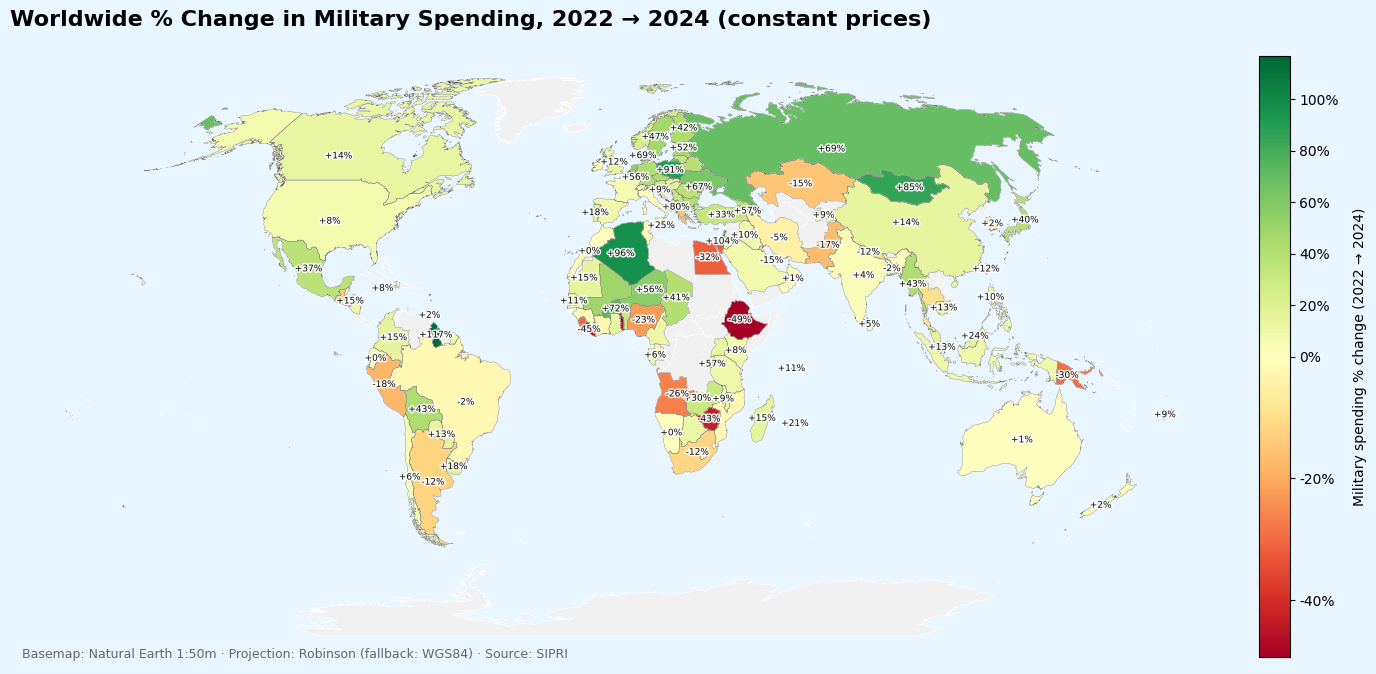

In [38]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.patheffects as pe
from pathlib import Path
import zipfile, requests
from shapely.geometry import MultiPolygon

# --------------------------------------------------------
# B) Natural Earth Admin-0: download/cache
# --------------------------------------------------------
NE_URL = "https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip"
cache_dir = Path("data/cache")
cache_dir.mkdir(parents=True, exist_ok=True)
zip_path = cache_dir / "ne_50m_admin_0_countries.zip"
extract_dir = cache_dir / "ne_50m_admin_0_countries"

if not extract_dir.exists():
    if not zip_path.exists():
        r = requests.get(NE_URL, timeout=60)
        r.raise_for_status()
        zip_path.write_bytes(r.content)
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(extract_dir)

world = gpd.read_file(str(extract_dir / "ne_50m_admin_0_countries.shp"))

# --------------------------------------------------------
# C) Harmonize names
# --------------------------------------------------------
name_fix = {
    "Congo, DR": "Democratic Republic of the Congo",
    "Congo, Republic": "Republic of the Congo",
    "Cote d'Ivoire": "Côte d'Ivoire",
    "Korea, South": "South Korea",
    "Korea, North": "North Korea",
    "Viet Nam": "Vietnam",
    "Lao PDR": "Laos",
    "Türkiye": "Turkey",
    "Eswatini": "Eswatini",
    "Czechia": "Czechia",
    "Russian Federation": "Russia",
    "United States of America": "United States of America",
    "Syrian Arab Republic": "Syria",
    "Iran": "Iran",
    "Bolivia": "Bolivia",
    "Tanzania": "Tanzania",
    "Moldova": "Moldova",
    "Venezuela": "Venezuela",
    "Micronesia, Fed. Sts.": "Federated States of Micronesia",
    "Timor Leste": "East Timor",
    "Palestine": "Palestine",
}

# --------------------------------------------------------
# A) INPUT DATA
# --------------------------------------------------------
df = pd.read_csv('military_spending_constant_2023.csv', sep=',', skiprows=5)
df = df[['Country', '2022', '2024']].copy()

# Clean + compute percent change
df = df.dropna(subset=['Country', '2022', '2024'])
df = df[(df['2022'] != 'xxx') & (df['2022'] != '...') & (df['2024'] != 'xxx') & (df['2024'] != '...')]
df['2022'] = pd.to_numeric(df['2022'], errors='coerce')
df['2024'] = pd.to_numeric(df['2024'], errors='coerce')
df = df.dropna(subset=['2022', '2024'])
df = df[df['2022'] > 0]

df['pct_increase'] = (df['2024'] - df['2022']) / df['2022'] * 100
df = df.rename(columns={'Country': 'ne_name'})
df['ne_name_fixed'] = df['ne_name'].map(lambda x: name_fix.get(x, x))

# --------------------------------------------------------
# D) Merge % change onto world geometries
# --------------------------------------------------------
merge = world.merge(
    df[["ne_name_fixed", "pct_increase"]],
    left_on="NAME",
    right_on="ne_name_fixed",
    how="left"
)

# --------------------------------------------------------
# E) Projection (Robinson preferred)
# --------------------------------------------------------
target_crs = None
for candidate in ["ESRI:54030", "EPSG:4326"]:
    try:
        merge_proj = merge.to_crs(candidate)
        target_crs = candidate
        break
    except Exception:
        continue
if target_crs is None:
    merge_proj = merge  # fallback

# Helper: representative point inside largest polygon (for label placement)
def inside_label_point(geom):
    if isinstance(geom, MultiPolygon):
        geom = max(geom.geoms, key=lambda g: g.area)
    return geom.representative_point().coords[0]

# ---- Declutter: keep labels spaced apart ----
def select_spread(df_pts, min_dist):
    """
    Greedy selection: keep countries with the largest |pct_increase| first,
    then skip any whose label point lies within min_dist of a kept one.
    """
    keep_idx = []
    # Sort by absolute change (big movers get priority)
    ordered = df_pts.reindex(df_pts['pct_increase'].abs().sort_values(ascending=False).index)
    xs = ordered['label_x'].to_numpy()
    ys = ordered['label_y'].to_numpy()
    for i, idx in enumerate(ordered.index):
        x, y = xs[i], ys[i]
        too_close = False
        for j in keep_idx:
            dx = x - ordered.loc[j, 'label_x']
            dy = y - ordered.loc[j, 'label_y']
            if (dx*dx + dy*dy) ** 0.5 < min_dist:
                too_close = True
                break
        if not too_close:
            keep_idx.append(idx)
    return ordered.loc[keep_idx]

# Choose a sensible spacing threshold based on CRS units
if target_crs == "ESRI:54030":
    # Robinson uses meters; ~600 km spacing helps declutter Europe/SEA/West Africa
    min_dist = 600_000
else:
    # Degrees (WGS84); ~5 degrees
    min_dist = 5.0

# --------------------------------------------------------
# F) Plot — diverging map + decluttered annotations
# --------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 8), facecolor="#e9f6ff")  # very light blue background

# Base countries (no data)
merge_proj.plot(ax=ax, facecolor="#f0f0f0", edgecolor="white", linewidth=0.4, zorder=1)

# Countries with data
countries = merge_proj.dropna(subset=["pct_increase"]).copy()

# Diverging colormap centered at 0 (red = decrease, green = increase)
vmin = countries["pct_increase"].min()
vmax = countries["pct_increase"].max()
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
cmap = plt.cm.RdYlGn  # red low, green high

countries.plot(
    ax=ax,
    column="pct_increase",
    cmap=cmap,
    linewidth=0.4,
    edgecolor="white",
    norm=norm,
    zorder=2
)

# Thin boundaries
countries.boundary.plot(ax=ax, linewidth=0.2, edgecolor="#444444", zorder=3)

# ---- Prepare label points and declutter ----
countries["label_x"], countries["label_y"] = zip(*countries.geometry.apply(inside_label_point))
labels = select_spread(countries[["NAME", "pct_increase", "label_x", "label_y"]].copy(), min_dist=min_dist)

# ---- Annotations (signed percentages) ----
for _, r in labels.iterrows():
    plt.text(
        r["label_x"], r["label_y"],
        f"{r['pct_increase']:+.0f}%",
        ha="center", va="center",
        fontsize=6.5, color="#111111",
        zorder=4, clip_on=True,
        path_effects=[pe.withStroke(linewidth=2.2, foreground="white", alpha=0.9)]
    )

# Colorbar
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.78, pad=0.02)
cbar.set_label("Military spending % change (2022 → 2024)", rotation=90, labelpad=10)
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, pos: f"{int(v)}%"))

# Title & caption
ax.set_title("Worldwide % Change in Military Spending, 2022 → 2024 (constant prices)",
             fontsize=16, loc="left", weight="bold")
ax.text(0.01, 0.01,
        "Basemap: Natural Earth 1:50m · Projection: Robinson (fallback: WGS84) · Source: SIPRI",
        transform=ax.transAxes, fontsize=9, color="#666666")

ax.set_axis_off()
ax.set_facecolor("#e9f6ff")
plt.tight_layout()
plt.savefig("world_increase_military_spending.png", dpi=600, bbox_inches="tight")
plt.show()


In [67]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path   # <-- add this
import zipfile, io, requests
# Harmonize a couple of names to match Natural Earth Admin-0 Countries

df_nato_sorted['ne_name'] = df_nato_sorted['Country'].replace(name_fix)

# --- 2) BASEMAP: use geodatasets for convenience (optional, for context/background) ---
# geodatasets offers naturalearth.land (handy as a light grey basemap under countries)
from geodatasets import get_path  # pip install geodatasets
land_path = get_path("naturalearth land")  # cached automatically
land = gpd.read_file(land_path)  # Polygon land masses
# land has no country boundaries; we use it only as a neutral background layer.

# --- 3) COUNTRIES GEOMETRY: fetch Admin-0 Countries from Natural Earth (country polygons) ---
# (geodatasets does not currently expose this layer)
ADMIN0_URL = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
cache_dir = Path("data/cache")
cache_dir.mkdir(parents=True, exist_ok=True)
admin_zip = cache_dir / "ne_110m_admin_0_countries.zip"
admin_dir = cache_dir / "ne_110m_admin_0_countries"

if not admin_dir.exists():
    if not admin_zip.exists():
        r = requests.get(ADMIN0_URL, timeout=60)
        r.raise_for_status()
        admin_zip.write_bytes(r.content)
    with zipfile.ZipFile(admin_zip, 'r') as zf:
        zf.extractall(admin_dir)

In [68]:
df_nato_sorted

,Country,2022,2024,pct_increase,ne_name
139,Poland,"18,057.20","34,488.30",90.99,Poland
125,Albania,267.50,481.50,80.00,Albania
158,Denmark,"5,801.20","9,781.60",68.61,Denmark
166,Luxembourg,543.40,849.40,56.31,Luxembourg
168,Netherlands,"14,540.70","22,439.20",54.32,Netherlands
131,Estonia,917.50,"1,392.70",51.79,Estonia
172,Sweden,"7,963.00","11,718.50",47.16,Sweden
135,Latvia,958.10,"1,404.80",46.62,Latvia
129,Czechia,"4,668.00","6,676.00",43.02,Czechia
159,Finland,"4,852.80","6,893.90",42.06,Finland


In [69]:
admin0 = gpd.read_file(str(admin_dir / "ne_110m_admin_0_countries.shp"))

# -------------------------
# 3. Keep only Europe + Turkey
# -------------------------
# Natural Earth uses uppercase column names
europe = admin0[(admin0['CONTINENT'] == 'Europe') | (admin0['NAME'] == 'Turkey')].copy()

# -------------------------
# 4. Merge NATO % change
# -------------------------
europe = admin0[admin0['CONTINENT'] == 'Europe'].copy()




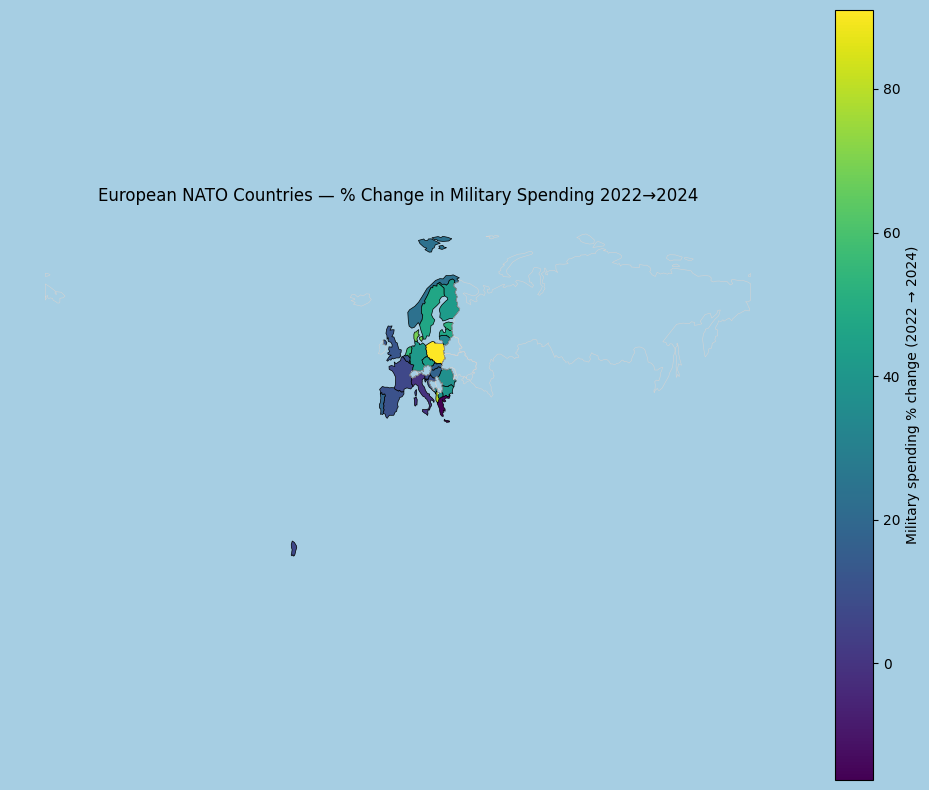

In [70]:
# -------------------------
# 4. Merge NATO % change
# -------------------------
merge = europe.merge(df_nato_sorted[['ne_name','pct_increase']], left_on='NAME', right_on='ne_name', how='left')

# -------------------------
# 5. Plot — Europe only
# -------------------------
fig, ax = plt.subplots(figsize=(10, 8))

# Choropleth for NATO countries
merge.dropna(subset=['pct_increase']).plot(
    ax=ax,
    column='pct_increase',
    legend=True,
    legend_kwds={'label': 'Military spending % change (2022 → 2024)'},
    edgecolor='black',
    linewidth=0.5
)

# Outline for non-NATO European countries
merge[merge['pct_increase'].isna()].plot(
    ax=ax, facecolor='none', edgecolor='lightgray', linewidth=0.4
)

ax.set_title('European NATO Countries — % Change in Military Spending 2022→2024', pad=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [72]:

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile, requests
from shapely.geometry import box
df = pd.read_csv('military_spending_constant_2023.csv', sep=',', skiprows=5)
df = df[['Country', '2022', '2024']].copy()

for col in ['2022', '2024']:
    df = df[df[col].notna()]
    df = df[(df[col] != 'xxx') & (df[col] != '...')]
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=['2022','2024'])

df = df[df['Country'].isin(nato_countries)].copy()
df['pct_increase'] = (df['2024'] - df['2022']) / df['2022'] * 100

# Fix name mismatches for Natural Earth
name_fix = {"Czech Republic": "Czechia"}
df['ne_name'] = df['Country'].replace(name_fix)

# -------------------------
# 2) Natural Earth Admin-0 Countries (download/cache once)
# -------------------------
ADMIN0_URL = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
cache_dir = Path("data/cache")
cache_dir.mkdir(parents=True, exist_ok=True)
admin_zip = cache_dir / "ne_110m_admin_0_countries.zip"
admin_dir = cache_dir / "ne_110m_admin_0_countries"

if not admin_dir.exists():
    if not admin_zip.exists():
        r = requests.get(ADMIN0_URL, timeout=60)
        r.raise_for_status()
        admin_zip.write_bytes(r.content)
    with zipfile.ZipFile(admin_zip, 'r') as zf:
        zf.extractall(admin_dir)

admin0 = gpd.read_file(str(admin_dir / "ne_110m_admin_0_countries.shp"))

# -------------------------
# 3) Keep Europe only (strict) and clip to mainland bbox
#    bbox (lon/lat): roughly mainland Europe; excludes Iceland/Canaries/Azores
# -------------------------
europe = admin0[admin0['CONTINENT'] == 'Europe'].copy()

# Mainland Europe bounding box
# tweak if you want a little more/less margin
bbox = box(-11, 34, 32, 72)   # (min_lon, min_lat, max_lon, max_lat)
europe_mainland = gpd.clip(europe, bbox)

# -------------------------
# 4) Merge your % change onto the polygons
# -------------------------
merge = europe_mainland.merge(
    df[['ne_name','pct_increase']],
    left_on='NAME',
    right_on='ne_name',
    how='left'
)

# -------------------------
# 5) Plot — Europe (mainland) only, yellow → dark red
# -------------------------


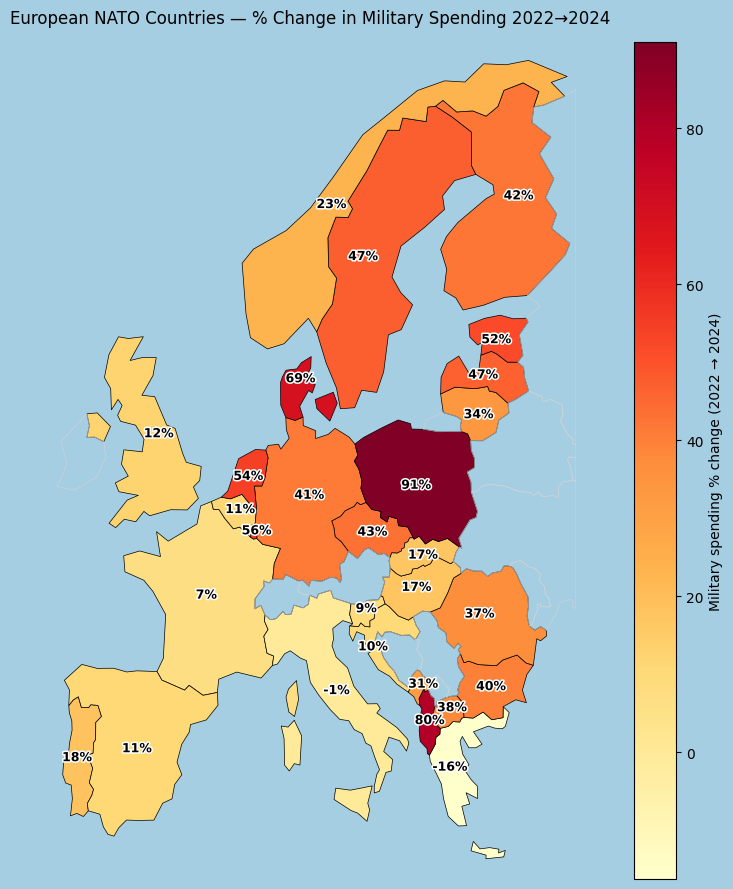

In [73]:
# -------------------------
# 5. Plot — Europe (mainland) only, yellow → dark red + labels
# -------------------------
import matplotlib.patheffects as pe
from shapely.geometry import Polygon, MultiPolygon

fig, ax = plt.subplots(figsize=(12, 9))

# Choropleth for NATO members with data
merge.dropna(subset=['pct_increase']).plot(
    ax=ax,
    column='pct_increase',
    cmap='YlOrRd',  # yellow -> dark red
    legend=True,
    legend_kwds={'label': 'Military spending % change (2022 → 2024)'},
    edgecolor='black',
    linewidth=0.5
)

# Outline other European countries for context
merge[merge['pct_increase'].isna()].plot(
    ax=ax, facecolor='none', edgecolor='lightgray', linewidth=0.4
)

# Optional: tiny-country nudges (lon, lat offsets in degrees)
nudges = {
    'Luxembourg': (0.2, 0.1),
    'Slovenia': (0.3, 0.15),
    'Montenegro': (0.25, 0.1),
    'North Macedonia': (0.25, 0.1),
    'Albania': (0.2, -0.05),
    'Belgium': (0.1, 0.2),
    'Netherlands': (0.1, 0.25),
    'Denmark': (0.25, 0.4)
}

# Helper: pick the largest polygon for labeling, then use a representative_point()
def label_point(geom):
    if isinstance(geom, MultiPolygon):
        geom = max(geom.geoms, key=lambda g: g.area)
    # representative_point() is guaranteed to lie within the polygon
    return geom.representative_point().coords[0]

# Add percentage labels directly on each NATO country shape
for _, row in merge.dropna(subset=['pct_increase']).iterrows():
    x, y = label_point(row.geometry)
    dx, dy = nudges.get(row['NAME'], (0.0, 0.0))
    ax.text(
        x + dx, y + dy,
        f"{row['pct_increase']:.0f}%",
        ha='center', va='center',
        fontsize=9, fontweight='bold', color='black',
        path_effects=[pe.withStroke(linewidth=2.2, foreground='white')]
    )

# Tighten the view to the mainland bounding box you defined earlier
ax.set_xlim(bbox.bounds[0], bbox.bounds[2])
ax.set_ylim(bbox.bounds[1], bbox.bounds[3])

ax.set_title('European NATO Countries — % Change in Military Spending 2022→2024', pad=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

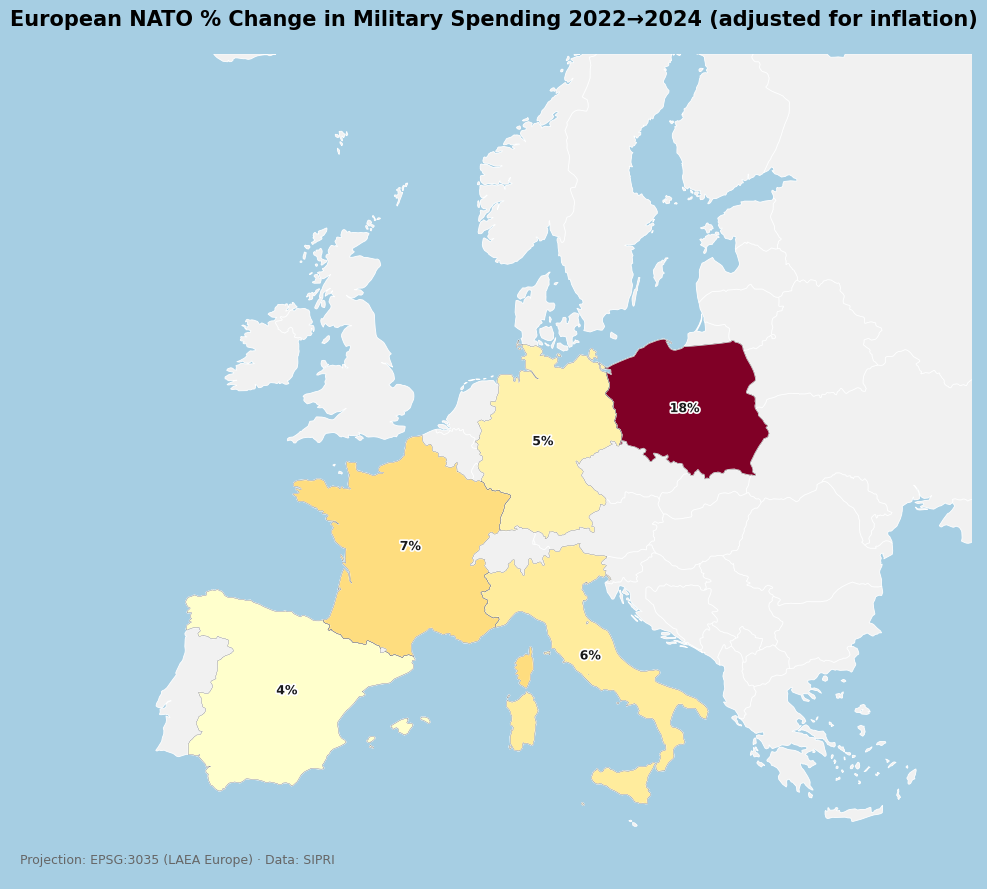

In [80]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from pathlib import Path
import zipfile, requests
from shapely.geometry import box, MultiPolygon

# --------------------------------------------------------
# A) DATA: assumes you already built df with 'ne_name' and 'pct_increase'
#    If not, keep your earlier cleaning. Only the map code is “new”.
# --------------------------------------------------------

# --------------------------------------------------------
# B) Load a nicer basemap: Natural Earth "Admin-0 Countries" (50m)
# --------------------------------------------------------
NE_URL = "https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip"
cache_dir = Path("data/cache")
cache_dir.mkdir(parents=True, exist_ok=True)
zip_path = cache_dir / "ne_50m_admin_0_countries.zip"
extract_dir = cache_dir / "ne_50m_admin_0_countries"

if not extract_dir.exists():
    if not zip_path.exists():
        r = requests.get(NE_URL, timeout=60)
        r.raise_for_status()
        zip_path.write_bytes(r.content)
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(extract_dir)

world = gpd.read_file(str(extract_dir / "ne_50m_admin_0_countries.shp"))

# Columns are usually uppercase in NE 50m
europe = world[world["CONTINENT"] == "Europe"].copy()

# --------------------------------------------------------
# C) Project to a Europe-friendly projection (EPSG:3035 - LAEA Europe)
#    and compute representative label points AFTER projection.
# --------------------------------------------------------
europe_3035 = europe.to_crs(3035)

# Merge your % change data (df[['ne_name','pct_increase']]) onto the map
merge = europe_3035.merge(
    df[["ne_name", "pct_increase"]],
    left_on="NAME",
    right_on="ne_name",
    how="left"
)

# Mainland extent (in projected meters) – tight and neat
# You can loosen/tighten this if you want more/less context
minx, miny, maxx, maxy = merge.total_bounds
# Clip a bit to central Europe to avoid far islands
# (values tuned for EPSG:3035; adjust to taste)
minx, miny, maxx, maxy = 2000000, 1200000, 6200000, 4800000
clip_box = gpd.GeoDataFrame(geometry=[box(minx, miny, maxx, maxy)], crs=merge.crs)
merge = gpd.overlay(merge, clip_box, how="intersection")

# Helper: label point inside largest polygon
def inside_label_point(geom):
    if isinstance(geom, MultiPolygon):
        geom = max(geom.geoms, key=lambda g: g.area)
    return geom.representative_point().coords[0]

# Precompute label points only for countries with data
labels = merge.dropna(subset=["pct_increase"]).copy()
labels["label_x"], labels["label_y"] = zip(*labels.geometry.apply(inside_label_point))

# --------------------------------------------------------
# D) Plot — refined aesthetics
# --------------------------------------------------------
plt.rcParams.update({"figure.facecolor": "#a6cee3"})
fig, ax = plt.subplots(figsize=(12, 9))

# Light, warm background for the axes
ax.set_facecolor("#a6cee3")   # soft ocean blue
# Draw all of Europe outlines (for context)
europe_outline = europe_3035.overlay(clip_box, how="intersection")
europe_outline.plot(ax=ax, facecolor="#f1f1f1", edgecolor="white", linewidth=0.6, zorder=1)

# Choropleth for NATO countries (those with data merged)
# Yellow -> dark red as requested
countries = merge.dropna(subset=["pct_increase"])
chor = countries.plot(
    ax=ax,
    column="pct_increase",
    cmap="YlOrRd",
    linewidth=0.7,
    edgecolor="white",
    zorder=2
)

# Thin gray hairline on top for subtle separation
countries.boundary.plot(ax=ax, linewidth=0.2, edgecolor="#444444", zorder=3)

# Labels on top of each country polygon (bold with white halo)
for _, r in labels.iterrows():
    ax.text(
        r["label_x"], r["label_y"],
        f"{r['pct_increase']:.0f}%",
        ha="center", va="center",
        fontsize=9, fontweight="bold", color="#1a1a1a",
        path_effects=[pe.withStroke(linewidth=2.4, foreground="white")],
        zorder=4
    )

# Colorbar — clean and compact
sm = plt.cm.ScalarMappable(
    norm=plt.Normalize(vmin=countries["pct_increase"].min(), vmax=countries["pct_increase"].max()),
    cmap="YlOrRd"
)
sm._A = []
#cbar = fig.colorbar(sm, ax=ax, shrink=0.82, pad=0.015)
#cbar.set_label("Military spending % change (2022 → 2024)", rotation=90, labelpad=12)
# format ticks as integers with a % sign
#cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, pos: f"{int(v)}%"))

# Title + subtitle + caption
ax.set_title("European NATO % Change in Military Spending 2022→2024 (adjusted for inflation)",
             fontsize=15, pad=10, loc="left", weight = 'bold')
ax.text(0.01, 0.02,
        "Projection: EPSG:3035 (LAEA Europe) · Data: SIPRI",
        transform=ax.transAxes, fontsize=9, color="#666666")

# Tight extent and no axes
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_axis_off()

plt.tight_layout()
plt.savefig(fname = 'europe_increase_military_spending.png',dpi = 1000)

plt.show()


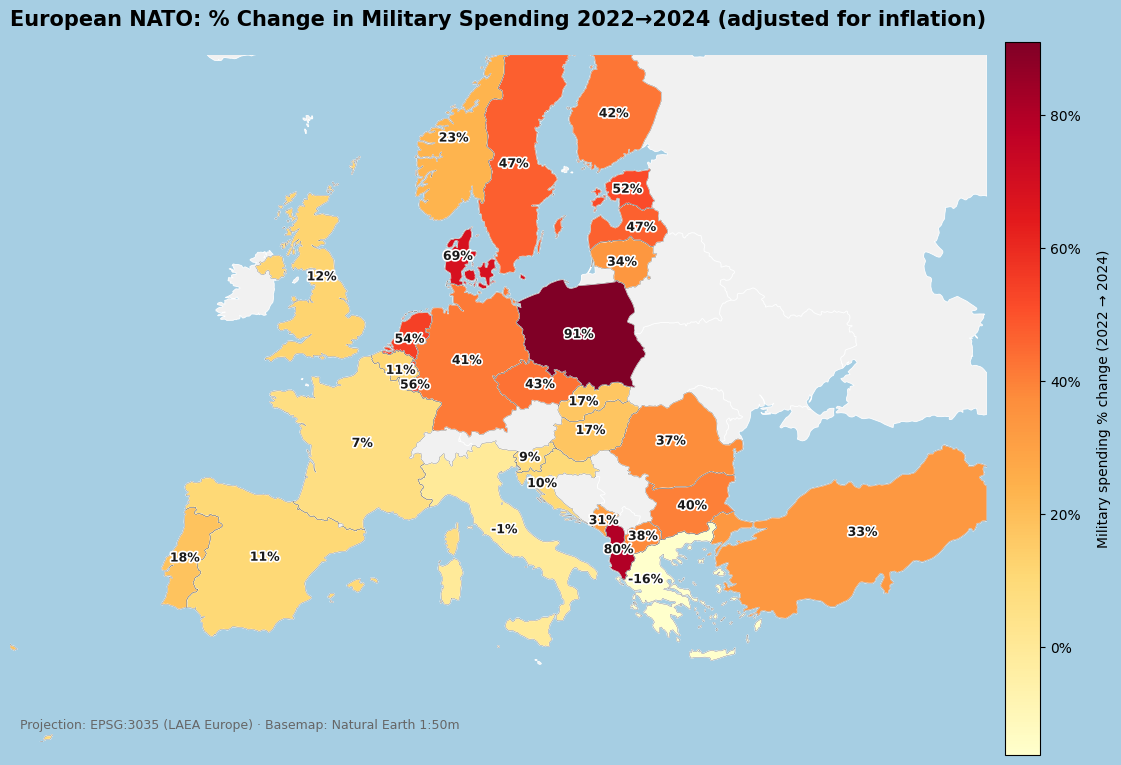

In [89]:
# -*- coding: utf-8 -*-
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from pathlib import Path
import zipfile, requests
from shapely.geometry import box, MultiPolygon

# ------------------------------------------
# Example data — replace with your own
# ------------------------------------------
df = pd.read_csv('military_spending_constant_2023.csv', sep=',', skiprows=5)
df = df[['Country', '2022', '2024']].copy()

for col in ['2022', '2024']:
    df = df[df[col].notna()]
    df = df[(df[col] != 'xxx') & (df[col] != '...')]
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=['2022','2024'])

df = df[df['Country'].isin(nato_countries)].copy()
df['pct_increase'] = (df['2024'] - df['2022']) / df['2022'] * 100

# Fix name mismatches for Natural Earth
name_fix = { "Czechia":"Czech Republic",     "Türkiye": "Turkey",}
df['ne_name'] = df['Country'].replace(name_fix)
#merge = europe.merge(df_nato_sorted[['ne_name','pct_increase']], left_on='NAME', right_on='ne_name', how='left')
#df = merge.copy()

# ------------------------------------------
# Load Natural Earth Admin-0 Countries (50m)
# ------------------------------------------
NE_URL = "https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip"
cache_dir = Path("data/cache")
cache_dir.mkdir(parents=True, exist_ok=True)
zip_path = cache_dir / "ne_50m_admin_0_countries.zip"
extract_dir = cache_dir / "ne_50m_admin_0_countries"

if not extract_dir.exists():
    if not zip_path.exists():
        r = requests.get(NE_URL, timeout=60)
        r.raise_for_status()
        zip_path.write_bytes(r.content)
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(extract_dir)

world = gpd.read_file(str(extract_dir / "ne_50m_admin_0_countries.shp"))

# ------------------------------------------
# Include Europe + Türkiye (ADM0_A3 == "TUR")
# ------------------------------------------
europe = world[(world["CONTINENT"] == "Europe") | (world["ADM0_A3"] == "TUR")].copy()

# normalize name field
name_col = "NAME_EN" if "NAME_EN" in europe.columns else "NAME"
europe["NAME_JOIN"] = europe[name_col].fillna(europe["NAME"])

# fix df names to match NE
df["ne_name"] = df["ne_name"].replace({"Türkiye": "Turkey", "Türkiye (Turkey)": "Turkey"})

# ------------------------------------------
# Project and merge data
# ------------------------------------------
europe_3035 = europe.to_crs(3035)
merge = europe_3035.merge(df, left_on="NAME_JOIN", right_on="ne_name", how="left")

# ------------------------------------------
# Set a custom bounding box to show all Europe + Türkiye
# ------------------------------------------
# These values work well in EPSG:3035
minx, miny, maxx, maxy = 1800000, 1000000, 7200000, 4800000
clip_box = gpd.GeoDataFrame(geometry=[box(minx, miny, maxx, maxy)], crs=merge.crs)

europe_outline = gpd.overlay(europe_3035, clip_box, how="intersection")
merge = gpd.overlay(merge, clip_box, how="intersection")

# ------------------------------------------
# Helper for label placement
# ------------------------------------------
def inside_label_point(geom):
    if isinstance(geom, MultiPolygon):
        geom = max(geom.geoms, key=lambda g: g.area)
    pt = geom.representative_point()
    return (pt.x, pt.y)

labels = merge.dropna(subset=["pct_increase"]).copy()
labels["label_x"], labels["label_y"] = zip(*labels.geometry.apply(inside_label_point))

# ------------------------------------------
# Plot
# ------------------------------------------
plt.rcParams.update({"figure.facecolor": "#a6cee3"})
fig, ax = plt.subplots(figsize=(12, 9))
ax.set_facecolor("#a6cee3")

# Outline
europe_outline.plot(ax=ax, facecolor="#f1f1f1", edgecolor="white", linewidth=0.6, zorder=1)

# Choropleth
countries = merge.dropna(subset=["pct_increase"])
chor = countries.plot(
    ax=ax,
    column="pct_increase",
    cmap="YlOrRd",
    linewidth=0.7,
    edgecolor="white",
    zorder=2
)
countries.boundary.plot(ax=ax, linewidth=0.2, edgecolor="#444444", zorder=3)

# Labels
for _, r in labels.iterrows():
    ax.text(
        r["label_x"], r["label_y"],
        f"{r['pct_increase']:.0f}%",
        ha="center", va="center",
        fontsize=9, fontweight="bold", color="#1a1a1a",
        path_effects=[pe.withStroke(linewidth=2.4, foreground="white")],
        zorder=4
    )

# Colorbar
import matplotlib as mpl
sm = plt.cm.ScalarMappable(
    norm=mpl.colors.Normalize(vmin=countries["pct_increase"].min(),
                              vmax=countries["pct_increase"].max()),
    cmap="YlOrRd"
)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, shrink=0.82, pad=0.015)
cbar.set_label("Military spending % change (2022 → 2024)", rotation=90, labelpad=12)
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, pos: f"{int(v)}%"))

# Title + caption
ax.set_title("European NATO: % Change in Military Spending 2022→2024 (adjusted for inflation)",
             fontsize=15, pad=10, loc="left", weight='bold')
ax.text(0.01, 0.02,
        "Projection: EPSG:3035 (LAEA Europe) · Basemap: Natural Earth 1:50m",
        transform=ax.transAxes, fontsize=9, color="#666666")

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_axis_off()
plt.tight_layout()
plt.savefig("europe_turkiye_military_spending_2.png", dpi=1000)
plt.show()


In [48]:
other_countries_spend = other_countries_spend.sort_values(by='2024', ascending = False)
other_countries_spend["cum_sum"] = other_countries_spend['2024'].cumsum()
needed = other_countries_spend[other_countries_spend["cum_sum"] < float(us_spend['2024'])]

needed_countries = needed['Country'].astype(str).tolist()
needed_spends = needed['2024'].astype(float).tolist()


## Change Spends to be in the order of billions
needed_spends = np.array(needed_spends)/1000
needed_spends = needed_spends.tolist()
us_spend['2024'] = float(us_spend['2024'])/1000

/var/folders/cw/m3xj051j4qdfbhhykf_lxz6r0000gp/T/ipykernel_13838/3575772295.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  needed = other_countries_spend[other_countries_spend["cum_sum"] < float(us_spend['2024'])]
/var/folders/cw/m3xj051j4qdfbhhykf_lxz6r0000gp/T/ipykernel_13838/3575772295.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  us_spend['2024'] = float(us_spend['2024'])/1000


In [105]:
# ---- Plot: US vs stacked "Next N countries" ----
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# -----------------------
# Economist / FT-like Matplotlib style
# -----------------------
def set_pubstyle_econ_ft(base_fontsize=12):
    mpl.rcParams.update({
        # Typography
        "font.family": ["IBM Plex Sans", "Source Sans 3", "Lato", "DejaVu Sans"],
        "font.size": base_fontsize,
        "axes.titlesize": base_fontsize * 1.6,
        "axes.labelsize": base_fontsize * 1.25,
        "legend.fontsize": base_fontsize * 0.95,
        "xtick.labelsize": base_fontsize * 1.0,
        "ytick.labelsize": base_fontsize * 1.0,

        # Lines & grid
        "axes.grid": True,
        "grid.linestyle": "-",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.35,
        "axes.axisbelow": True,

        # Spines
        "axes.spines.top": False,
        "axes.spines.right": False,

        # Figure
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",

        # Legend
        "legend.frameon": False,
        "legend.loc": "upper left",

        # Tick params
        "xtick.major.size": 0,
        "ytick.major.size": 0,
        "xtick.minor.size": 0,
        "ytick.minor.size": 0,
    })

def economist_axis_touches(ax):
    ax.spines["left"].set_linewidth(1.1)
    ax.spines["bottom"].set_linewidth(1.1)
    ax.spines["left"].set_color("#3a3a3a")
    ax.spines["bottom"].set_color("#3a3a3a")
    ax.grid(axis="y", color="#8a8a8a")
    ax.grid(axis="x", visible=False)

def add_caption(fig, text, y_offset=0.02):
    fig.text(0.0, y_offset, text, ha="left", va="bottom", fontsize=10, color="#5a5a5a")

/var/folders/cw/m3xj051j4qdfbhhykf_lxz6r0000gp/T/ipykernel_95470/477789150.py:79: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.set_ylim(0, max(float(us_spend['2024']), sum(needed_spends)) * 1.15)
/var/folders/cw/m3xj051j4qdfbhhykf_lxz6r0000gp/T/ipykernel_95470/477789150.py:109: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  us_val = float(us_spend[year_label])
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 

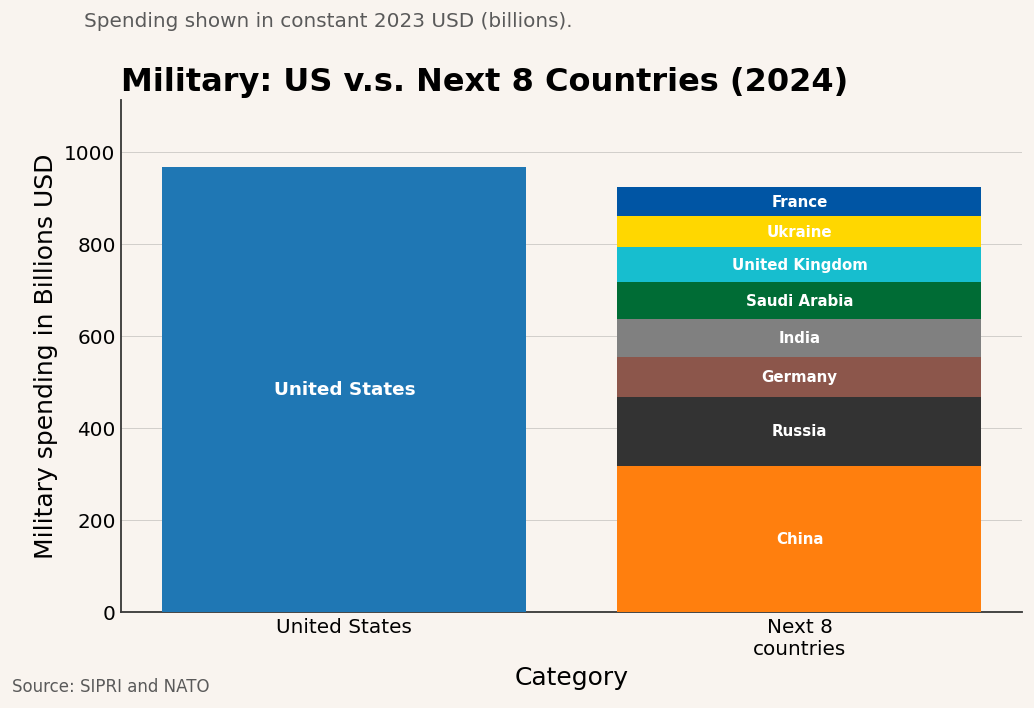

In [6]:
# ---- Plot: US vs stacked "Next N countries" ----
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# -----------------------
# Economist / FT-like Matplotlib style
# -----------------------
def set_pubstyle_econ_ft(base_fontsize=12):
    mpl.rcParams.update({
        # Typography
        "font.family": ["IBM Plex Sans", "Source Sans 3", "Lato", "DejaVu Sans"],
        "font.size": base_fontsize,
        "axes.titlesize": base_fontsize * 1.6,
        "axes.labelsize": base_fontsize * 1.25,
        "legend.fontsize": base_fontsize * 0.95,
        "xtick.labelsize": base_fontsize * 1.0,
        "ytick.labelsize": base_fontsize * 1.0,

        # Lines & grid
        "axes.grid": True,
        "grid.linestyle": "-",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.35,
        "axes.axisbelow": True,

        # Spines
        "axes.spines.top": False,
        "axes.spines.right": False,

        # Figure
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",

        # Legend
        "legend.frameon": False,
        "legend.loc": "upper left",

        # Tick params
        "xtick.major.size": 0,
        "ytick.major.size": 0,
        "xtick.minor.size": 0,
        "ytick.minor.size": 0,
    })

def economist_axis_touches(ax):
    ax.spines["left"].set_linewidth(1.1)
    ax.spines["bottom"].set_linewidth(1.1)
    ax.spines["left"].set_color("#3a3a3a")
    ax.spines["bottom"].set_color("#3a3a3a")
    ax.grid(axis="y", color="#8a8a8a")
    ax.grid(axis="x", visible=False)

def add_caption(fig, text, y_offset=0.02):
    fig.text(0.0, y_offset, text, ha="left", va="bottom", fontsize=10, color="#5a5a5a")

# -----------------------------------------
# Example data (replace with your real data)
# -----------------------------------------
year_label = "2024"  # keep consistent with title
#us_spend = {year_label: 916_000}  # millions, example only

#needed_countries = ["China", "Russia", "India", "UK", "Germany"]
#needed_spends =    [296_000, 109_000,  87_000,  74_000,   66_000]  # millions, example only

xtick_step = 1  # not crucial here, but kept in case you reuse

# -----------------------
# Build the plot
# -----------------------
set_pubstyle_econ_ft(base_fontsize=12)

fig = plt.figure(figsize=(10, 6.2), facecolor="#f9f4ef")
ax = plt.gca()
ax.set_facecolor("#f9f4ef")

economist_axis_touches(ax)
ax.set_ylim(0, max(float(us_spend['2024']), sum(needed_spends)) * 1.15)

# Titles & labels
ax.set_xlabel("Category")
ax.set_ylabel("Military spending in Billions USD")
ax.set_title(f"Military: US v.s. Next 8 Countries ({year_label})", loc="left", fontweight="bold")

subtitle = "Spending shown in constant 2023 USD (billions)."

fig.suptitle(subtitle, x=0.06, y=0.94, ha="left", fontsize=12, color="#5a5a5a")

# X axis ticks (no real 'years' here, so use a neutral locator)
ax.xaxis.set_major_locator(mticker.FixedLocator([0, 1]))
country_colors = {
    "Russia": "#333333",                  # near-black
    "China": "#FF7F0E",                   # orange
    "United States of America": "#1f77b4",# strong blue
    "United Kingdom": "#17becf",          # cyan / teal
    "France": "#0055A4",                  # deep flag blue
    "Ukraine": "#FFD700",                 # golden yellow
    "Germany": "#8c564b",                 # brownish gray
    "Saudi Arabia": "#006C35"             # emerald green
}



# Bars
x_positions = [0, 1]
us_name = "United States"

us_val = float(us_spend[year_label])
us_bar = ax.bar(x_positions[0], us_val, zorder=3, color="#1F77B4")  # optional color
# Put label in the middle of the bar
ax.text(
    x_positions[0], us_val/2, us_name,
    ha="center", va="center", fontsize=11, color="white", fontweight="bold"
)

bottom = 0.0
for cname, cval in zip(needed_countries, needed_spends):
    bar = ax.bar(
        x_positions[1], cval, bottom=bottom, zorder=3,
        color=country_colors.get(cname, "gray")  # fallback if not mapped
    )
    
    # Position text in the middle of the segment
    ax.text(
        x_positions[1], bottom + cval/2, cname,
        ha="center", va="center", fontsize=9, color="white", fontweight="bold"
    )
    
    bottom += cval

# X tick labels (two-line label for the right bar)
ax.set_xticks(x_positions)
ax.set_xticklabels([us_name, f"Next {len(needed_countries)}\ncountries"])

# Legend (list stacked countries clearly)
#ax.legend(title="Stacked countries", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=True)

# Caption/source (optional)
add_caption(fig, "Source: SIPRI and NATO")

plt.tight_layout(rect=[0, 0, 0.86, 0.95])  # leave room for the outside legend & suptitle
plt.savefig(fname = 'total_military_spending_comparison.png',dpi = 1000)

plt.show()


In [7]:

# NATO members (as listed in your dataset — adjust names if needed)
nato_countries = [
    "United States of America", "Canada", "United Kingdom", "France", "Germany",
    "Italy", "Spain", "Portugal", "Greece", "Turkey", "Belgium", "Netherlands",
    "Luxembourg", "Norway", "Denmark", "Iceland", "Poland", "Czech Republic",
    "Hungary", "Slovakia", "Slovenia", "Romania", "Bulgaria", "Estonia",
    "Latvia", "Lithuania", "Croatia", "Albania", "Montenegro", "North Macedonia"
]

# List of European NATO countries (exclude US & Canada)
# European NATO members
european_nato = [
    "Albania",
    "Belgium",
    "Bulgaria",
    "Croatia",
    "Czechia",
    "Denmark",
    "Estonia",
    "France",
    "Germany",
    "Greece",
    "Hungary",
    "Iceland",
    "Italy",
    "Latvia",
    "Lithuania",
    "Luxembourg",
    "Montenegro",
    "Netherlands",
    "North Macedonia",
    "Norway",
    "Poland",
    "Portugal",
    "Romania",
    "Slovakia",
    "Slovenia",
    "Spain",
    "United Kingdom",
    "Türkiye"   # transcontinental but NATO member, listed as "Türkiye" in SIPRI
]



# Canada
canada_nato = ["Canada"]

# United States
us_nato = ["United States of America"]


# Load dataset
country_military_spending = pd.read_csv(
    "military_expenditures_in_shared_of_gdp.tsv",
    sep="\t",
    skiprows=5
)

# Keep only NATO members
nato_spending = country_military_spending[
    country_military_spending["Country"].isin(nato_countries)
]

us_military_spending = country_military_spending[
    country_military_spending["Country"].isin(us_nato)
]


# Reshape to long format
nato_long = nato_spending.melt(
    id_vars=["Country"],
    var_name="Year",
    value_name="Spending"
)

# Keep only numeric years
nato_long = nato_long[nato_long["Year"].str.isnumeric()]
nato_long["Year"] = nato_long["Year"].astype(int)
nato_long = nato_long[nato_long["Spending"] != "..."]

nato_long["Spending"] = (
    nato_long["Spending"]
    .replace(r"%", "", regex=True)
    .astype(float)
)
nato_long["Spending"] = nato_long["Spending"].astype(float)
europe_long = nato_long[nato_long["Country"].isin(european_nato)]



us_long = us_military_spending.melt(
    id_vars=["Country"],
    var_name="Year",
    value_name="Spending"
)

# Convert Year to int (if they are strings)
us_long = us_long[us_long["Year"].str.isnumeric()]

us_long["Year"] = us_long["Year"].astype(int)
us_long["Spending"] = (
    us_long["Spending"]
    .replace(r"%", "", regex=True)
    .astype(float)
)
us_long["Spending"] = us_long["Spending"].astype(float)

# Build a long-form dataframe for ALL countries (no NATO filter)



all_long = country_military_spending.melt(
    id_vars=["Country"],
    var_name="Year",
    value_name="Spending"
)

# Clean it the same way
all_long = all_long[all_long["Year"].astype(str).str.isnumeric()].copy()
all_long["Year"] = all_long["Year"].astype(int)

all_long = all_long[~all_long["Spending"].isin(["...", ". ."])].copy()
all_long["Spending"] = (
    all_long["Spending"].astype(str)
    .str.replace("%", "", regex=False)
    .str.strip()
)
all_long = all_long[pd.to_numeric(all_long["Spending"], errors="coerce").notna()].copy()
all_long["Spending"] = all_long["Spending"].astype(float)

# Russia & China series (averages per year in case of duplicates)
russia_avg = (
    all_long[all_long["Country"] == "Russia"]
    .groupby("Year")["Spending"].mean().reset_index()
)
china_avg = (
    all_long[all_long["Country"] == "China"]
    .groupby("Year")["Spending"].mean().reset_index()
)






findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sa

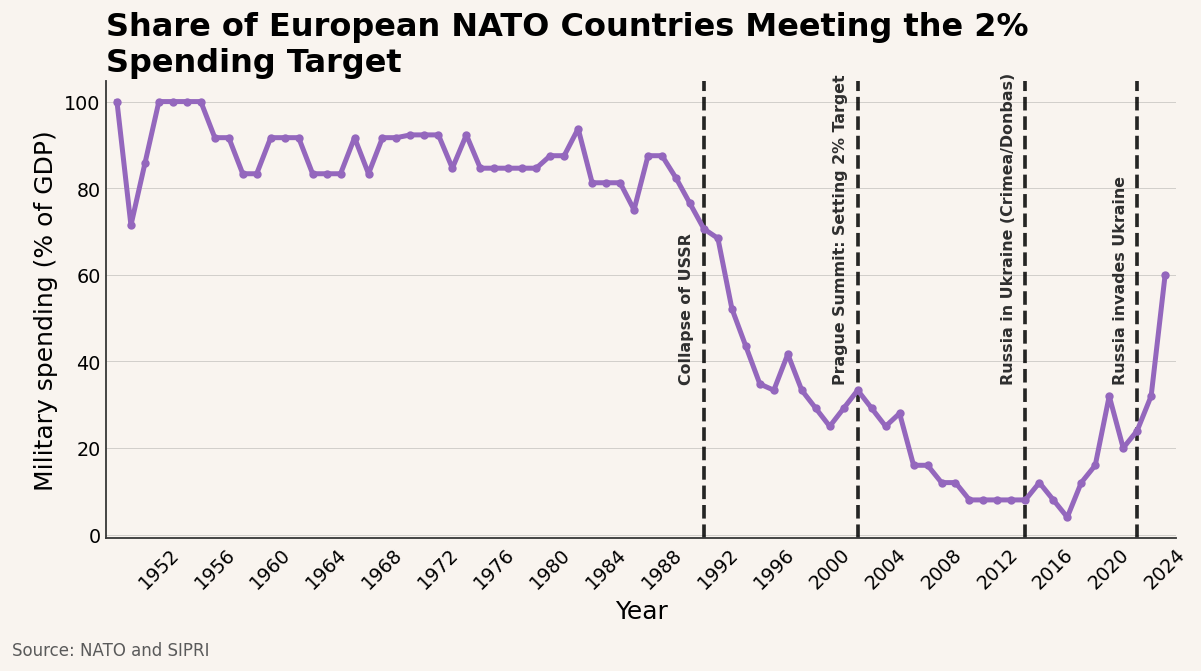

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter to European NATO countries
eu = nato_long[nato_long["Country"].isin(european_nato)].copy()

# For each year: percentage of countries with Spending >= 2 (only among countries with data that year)
eu_yearly = (
    eu.groupby("Year")["Spending"]
      .agg(total=lambda s: s.notna().sum(),
           hits=lambda s: (s >= 2).sum())
      .reset_index()
)
eu_yearly["pct_above_2"] = eu_yearly["hits"] / eu_yearly["total"] * 100

# Plot
fig = plt.figure(figsize=(10, 6.2), facecolor="#f9f4ef")  # very light tan
ax = plt.gca()
ax.set_facecolor("#f9f4ef")  # match background for the plotting area
set_pubstyle_econ_ft(base_fontsize=12)

ax.tick_params(axis="both", which="major", labelsize=14)
economist_axis_touches(ax)
ax.plot(
    eu_yearly["Year"], eu_yearly["pct_above_2"],
    linewidth=3, marker="o", markersize=4, color="#9467BD",  # purple (colorblind-friendly)
    label="European NATO at ≥ 2%"
)

events = [
    (1991, "Collapse of USSR"),
    (2002, "Prague Summit: Setting 2% Target"),
    (2014, "Russia in Ukraine (Crimea/Donbas)"),
    (2022, "Russia invades Ukraine")
]


# Draw the vertical lines
for x, _ in events:
    ax.axvline(x=x, color="black", linestyle="--", linewidth=2.2, alpha=0.85, zorder=1)

# Place labels *inside* the plot, close to bottom
ymin, ymax = ax.get_ylim()
label_y = ymin + 0.1 * (ymax - ymin)   # 10% above bottom

for x, label in events:
    ax.text(
        x - 1.75, label_y + 25,
        label,
        rotation=90,
        fontsize=9.5,
        va="bottom", ha="left",
        color="#2f2f2f", weight = 'bold',
        bbox=dict(facecolor="none", edgecolor="none", pad=2.2),
        zorder=5
    )
# Formatting
#ax.title("Share of European NATO Countries Meeting the 2% Guideline", fontsize=18, fontweight="bold")


subtitle = "Spending shown in constant 2023 USD (billions)."


ax.set_title(f"Share of European NATO Countries Meeting the 2% \nSpending Target", loc="left", fontweight="bold")
#fig.suptitle(subtitle, x=0.06, y=0.94, ha="left", fontsize=12, color="#5a5a5a")

ax.set_xlabel("Year")
ax.set_ylabel("Military spending (% of GDP)")



# Ticks: nice integer years if your x is datetime/int; adjust as needed
ax.margins(x=0.01)
ax.tick_params(axis="both", which="major", labelsize=11.5)

# Caption / source note
add_caption(fig, "Source: NATO and SIPRI")
import matplotlib.ticker as mticker

# Get current number of ticks
import matplotlib.ticker as mticker

# Get how many ticks you currently have
num_ticks = len(ax.get_xticks())

# Request roughly double
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=num_ticks * 2))
ax.tick_params(axis="x", rotation=45)   # rotate all x tick labels
plt.tight_layout(rect=[0, 0.04, 1, 0.92])
plt.savefig(fname = 'european_countries_meeting_2_percent_target.png',dpi = 1000)

plt.show()

In [97]:
import pandas as pd

# Load the CSV
file_path = "social_spending_ssocx.csv"
df = pd.read_csv(file_path)

# Select and rename relevant columns
df_clean = df[["Reference area", "TIME_PERIOD", "OBS_VALUE"]].rename(
    columns={
        "Reference area": "Country",
        "TIME_PERIOD": "Year",
        "OBS_VALUE": "Public social spending (% of GDP)"
    }
)

# Convert year to integer
df_clean["Year"] = df_clean["Year"].astype(int)

# Convert spending to numeric
df_clean["Public social spending (% of GDP)"] = pd.to_numeric(df_clean["Public social spending (% of GDP)"], errors="coerce")

print(df_clean.head())
df_clean = df_clean.dropna()
df_clean

   Country  Year  Public social spending (% of GDP)
0  Romania  1980                                NaN
1  Romania  1981                                NaN
2  Romania  1982                                NaN
3  Romania  1983                                NaN
4  Romania  1984                                NaN


,Country,Year,Public social spending (% of GDP)
91,Norway,2006,19.40
92,Norway,2007,19.52
93,Norway,2008,19.17
94,Norway,2009,22.41
95,Norway,2010,22.00
...,...,...,...
1901,Costa Rica,2018,12.43
1902,Costa Rica,2019,12.33
1903,Costa Rica,2020,14.37
1904,Costa Rica,2021,12.70


In [103]:
df_clean[df_clean['Country'] == 'Czechia']

,Country,Year,Public social spending (% of GDP)
1738,Czechia,1990,13.93
1739,Czechia,1991,14.97
1740,Czechia,1992,15.24
1741,Czechia,1993,15.51
1742,Czechia,1994,15.59
1743,Czechia,1995,15.85
1744,Czechia,1996,15.88
1745,Czechia,1997,16.63
1746,Czechia,1998,16.96
1747,Czechia,1999,17.59


findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sa

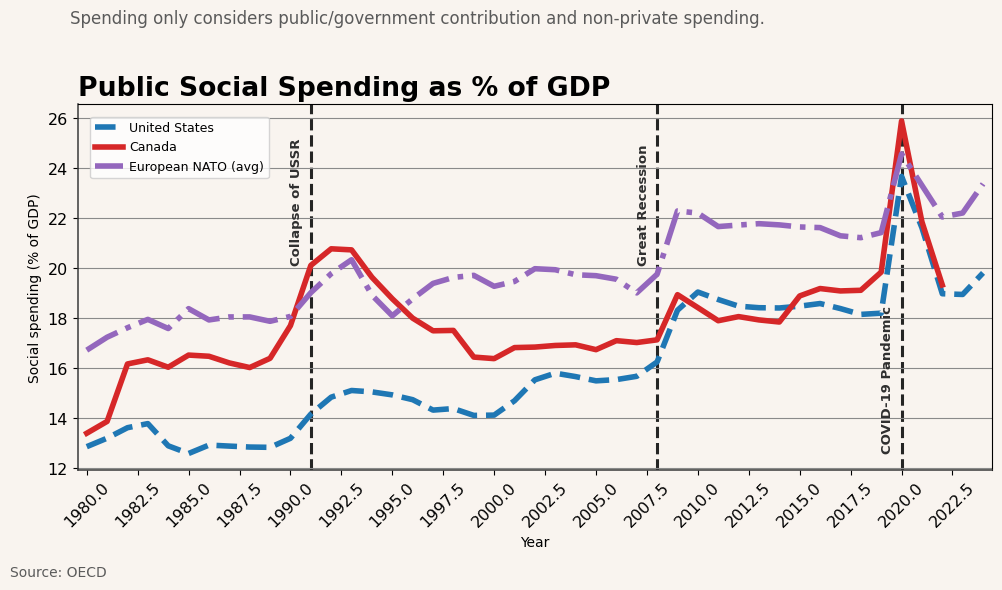

In [106]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_clean

# Full NATO list you gave
nato_countries = [
    "United States", "Canada", "United Kingdom", "France", "Germany",
    "Italy", "Spain", "Portugal", "Greece", "Türkiye", "Belgium", "Netherlands",
    "Luxembourg", "Norway", "Denmark", "Iceland", "Poland", "Czechia",
    "Hungary", "Slovakia", "Slovenia", "Romania", "Bulgaria", "Estonia",
    "Latvia", "Lithuania", "Croatia", "Albania", "Montenegro", "North Macedonia"
]

# Filter only NATO countries present in dataset
df_nato = df[df["Country"].isin(nato_countries)].copy()

# Filter for Year >= 1949
df_nato = df_nato[df_nato["Year"] >= 1949]

# Split categories
us = df_nato[df_nato["Country"] == "United States"]
us = us.sort_values(by = 'Year')
canada = df_nato[df_nato["Country"] == "Canada"]
canada = canada.sort_values(by = 'Year')

# European subset (exclude US and Canada)
europe = df_nato[~df_nato["Country"].isin(["United States","Canada"])]
europe = europe.sort_values(by = 'Year')

# Compute average across European NATO members by year
europe_avg = europe.groupby("Year")["Public social spending (% of GDP)"].mean().reset_index()

# Plot
fig = plt.figure(figsize=(10, 6.2), facecolor="#f9f4ef")  # very light tan
ax = plt.gca()
ax.set_facecolor("#f9f4ef")  # match background for the plotting area
set_pubstyle_econ_ft(base_fontsize=12)

ax.tick_params(axis="both", which="major", labelsize=14)
economist_axis_touches(ax)


events = [
    (1991, "Collapse of USSR"),
   # (2001, "US invades Afghanistan"),
    (2008, "Great Recession"),
    (2020, "COVID-19 Pandemic"),
]


# Draw the vertical lines
for x, _ in events:
    ax.axvline(x=x, color="black", linestyle="--", linewidth=2.2, alpha=0.85, zorder=1)

# Place labels *inside* the plot, close to bottom
ymin, ymax = ax.get_ylim()
label_y = ymin + 0.1 * (ymax - ymin)   # 10% above bottom


for x, label in events:
    if x != 2020:
        ax.text(
            x - 1., label_y + 20,
            label,
            rotation=90,
            fontsize=9.5,
            va="bottom", ha="left",
            color="#2f2f2f", weight = 'bold',
            bbox=dict(facecolor="none", edgecolor="none", pad=2.2),
            zorder=5
        )
    else:
        ax.text(
            x - 1., label_y + 12.5,
            label,
            rotation=90,
            fontsize=9.5,
            va="bottom", ha="left",
            color="#2f2f2f", weight = 'bold',
            bbox=dict(facecolor="none", edgecolor="none", pad=2.2),
            zorder=5
        )
# Formatting
#ax.title("Share of European NATO Countries Meeting the 2% Guideline", fontsize=18, fontweight="bold")



ax.plot(us["Year"], us["Public social spending (% of GDP)"], label="United States", color="#1F77B4",linestyle="--",linewidth=4,)
ax.plot(canada["Year"], canada["Public social spending (% of GDP)"], label="Canada", color="#D62728",linewidth=4,)
ax.plot(europe_avg["Year"], europe_avg["Public social spending (% of GDP)"], label="European NATO (avg)",color="#9467BD", linewidth=4, linestyle="-.",)
ax.set_title(f"Public Social Spending as % of GDP", loc="left", fontweight="bold")


ax.set_xlabel("Year")
ax.set_ylabel("Social spending (% of GDP)")


subtitle = "Spending only considers public/government contribution and non-private spending."

fig.suptitle(subtitle, x=0.06, y=0.94, ha="left", fontsize=12, color="#5a5a5a")

#fig.suptitle(subtitle, x=0.06, y=0.94, ha="left", fontsize=12, color="#5a5a5a")

ax.set_xlabel("Year")
leg = ax.legend(
    ncol=1,
    frameon=True,        # show background panel
    facecolor="white",   # solid white background
    edgecolor="#cccccc", # subtle gray border
    handlelength=2.2,
    handletextpad=0.5,
    borderaxespad=1.0,
    loc="upper left",
    fontsize=9
)

# Ticks: nice integer years if your x is datetime/int; adjust as needed
ax.margins(x=0.01)
ax.tick_params(axis="both", which="major", labelsize=11.5)

# Caption / source note
add_caption(fig, "Source: OECD ")
import matplotlib.ticker as mticker

# Get current number of ticks
import matplotlib.ticker as mticker

# Get how many ticks you currently have
num_ticks = len(ax.get_xticks())

# Request roughly double
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=num_ticks * 2))
ax.tick_params(axis="x", rotation=45)   # rotate all x tick labels
plt.tight_layout(rect=[0, 0.04, 1, 0.92])
plt.savefig(fname = 'nato_countries_social_spending.png',dpi = 1000)

plt.show()

   Country  Year  Public social spending (% of GDP)
0  Romania  1980                                NaN
1  Romania  1981                                NaN
2  Romania  1982                                NaN
3  Romania  1983                                NaN
4  Romania  1984                                NaN


,Country,Year,Public social spending (% of GDP)
91,Norway,2006,19.404
92,Norway,2007,19.520
93,Norway,2008,19.169
94,Norway,2009,22.415
95,Norway,2010,22.001
...,...,...,...
1901,Costa Rica,2018,12.434
1902,Costa Rica,2019,12.326
1903,Costa Rica,2020,14.372
1904,Costa Rica,2021,12.701


findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sa

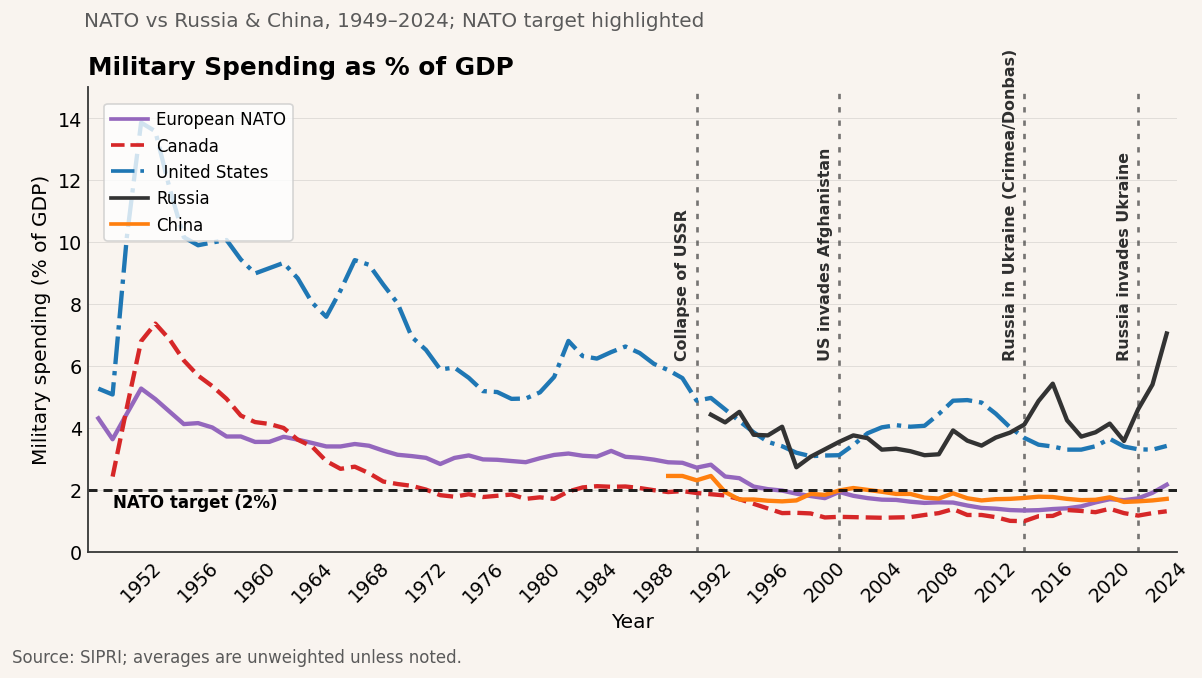

In [76]:
import matplotlib as mpl
import matplotlib.pyplot as plt

europe_grouped = (
    nato_long[nato_long["Country"].isin(european_nato)]
    .groupby(["Year"])["Spending"]
)

europe_mean = europe_grouped.mean()
europe_std = europe_grouped.std()


# Canada
canada_avg = (
    nato_long[nato_long["Country"].isin(canada_nato)]
    .groupby("Year")["Spending"]
    .mean()
    .reset_index()
)

# United States
us_avg = (
    nato_long[nato_long["Country"].isin(us_nato)]
    .groupby("Year")["Spending"]
    .mean()
    .reset_index()
)

# -----------------------
# Plot with Russia & China (colorblind-friendly palette)
# -----------------------
fig = plt.figure(figsize=(10, 6.2), facecolor="#f9f4ef")  # very light tan
ax = plt.gca()
ax.set_facecolor("#f9f4ef")  # match background for the plotting area


# European NATO average (purple)
ax.plot(
    europe_mean.index, europe_mean.values,
    linewidth=2.6, color="#9467BD", label="European NATO"
)

# Canada (red, dashed)
ax.plot(
    canada_avg["Year"], canada_avg["Spending"],
    linewidth=2.6, linestyle="--", color="#D62728", label="Canada"
)

# United States (blue, dash-dot)
ax.plot(
    us_avg["Year"], us_avg["Spending"],
    linewidth=2.6, linestyle="-.", color="#1F77B4", label="United States"
)

# Russia (near-black)
ax.plot(
    russia_avg["Year"], russia_avg["Spending"],
    linewidth=2.6, color="#333333", label="Russia"
)

# China (orange)
ax.plot(
    china_avg["Year"], china_avg["Spending"],
    linewidth=2.6, color="#FF7F0E", label="China"
)

ax.text(
        1950, 1.3,
        "NATO target (2%)",
        fontsize=10,
        va="bottom", ha="left",
        color="#000000", weight = 'bold',
        bbox=dict(facecolor="none", edgecolor="none", pad=2.2),
        zorder=5
    )


# NATO guideline
ax.axhline(2, color="#0c0c0c", linestyle=(0, (3, 2)), linewidth=1.8, alpha=0.9)

# Event markers (thin, tidy, labeled)
events = [
    (1991, "Collapse of USSR"),
    (2001, "US invades Afghanistan"),
    (2014, "Russia in Ukraine (Crimea/Donbas)"),
    (2022, "Russia invades Ukraine"),
]

for x, _ in events:
    ax.axvline(x=x, color="#2f2f2f", linestyle=(0, (2, 3)), linewidth=1.6, alpha=0.65, zorder=1)

ymin, ymax = ax.get_ylim()
label_y = ymin + 0.06 * (ymax - ymin)   # low, but inside the chart

for x, label in events:
    ax.text(
        x - 1.5, label_y + 5,
        label,
        rotation=90,
        fontsize=9.5,
        va="bottom", ha="left",
        color="#2f2f2f", weight = 'bold',
        bbox=dict(facecolor="none", edgecolor="none", pad=2.2),
        zorder=5
    )

# Axes formatting
economist_axis_touches(ax)
ax.set_ylim(0, 15)
ax.set_xlabel("Year")
ax.set_ylabel("Military spending (% of GDP)")

# Title + subtitle (FT/Economist style: bold title, lighter subtitle)
title = "Military Spending as % of GDP"
subtitle = "NATO vs Russia & China, 1949–2024; NATO target highlighted"
ax.set_title(title, loc="left", fontweight="bold", pad=8)
fig.suptitle(subtitle, x=0.06, y=0.90, ha="left", fontsize=12, color="#5a5a5a")

# Legend (with opaque background for clarity)
leg = ax.legend(
    ncol=1,
    frameon=True,        # show background panel
    facecolor="white",   # solid white background
    edgecolor="#cccccc", # subtle gray border
    handlelength=2.2,
    handletextpad=0.5,
    borderaxespad=1.0,
    loc="upper left",
    fontsize=10
)

# Standardize line thickness inside legend
for line in leg.get_lines():
    line.set_linewidth(2.2)

# Ticks: nice integer years if your x is datetime/int; adjust as needed
ax.margins(x=0.01)
ax.tick_params(axis="both", which="major", labelsize=11.5)

# Caption / source note
add_caption(fig, "Source: SIPRI; averages are unweighted unless noted.")
import matplotlib.ticker as mticker

# Get current number of ticks
import matplotlib.ticker as mticker

# Get how many ticks you currently have
num_ticks = len(ax.get_xticks())

# Request roughly double
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=num_ticks * 2))
ax.tick_params(axis="x", rotation=45)   # rotate all x tick labels
plt.tight_layout(rect=[0, 0.04, 1, 0.92])
plt.savefig(fname = 'countries_military_spending.png',dpi = 1000)

plt.show()


/var/folders/cw/m3xj051j4qdfbhhykf_lxz6r0000gp/T/ipykernel_95470/2784119615.py:88: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = (df.sort_values(["Country", "Year"])
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato

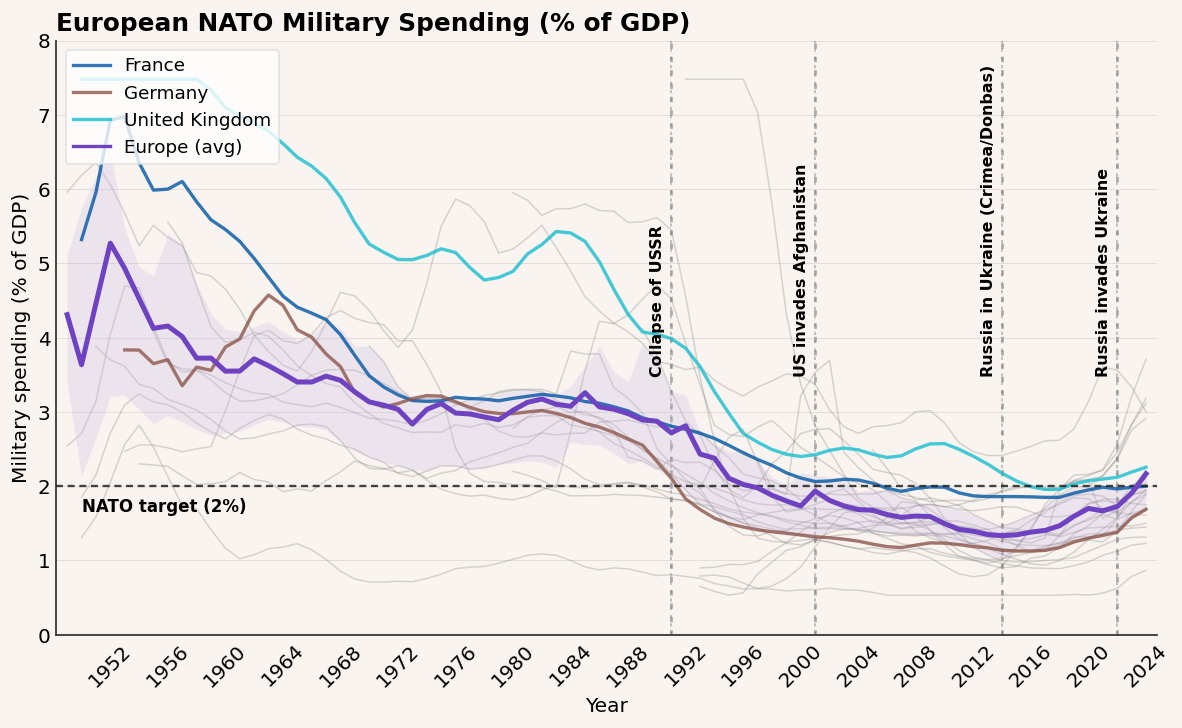

In [77]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# -----------------------
# Economist / FT-like Matplotlib style
# -----------------------
def set_pubstyle_econ_ft(base_fontsize=12):
    mpl.rcParams.update({
        # Typography
        "font.family": ["IBM Plex Sans", "Source Sans 3", "Lato", "DejaVu Sans"],  
        "font.size": base_fontsize,
        "axes.titlesize": base_fontsize * 1.6,
        "axes.labelsize": base_fontsize * 1.25,
        "legend.fontsize": base_fontsize * 0.95,
        "xtick.labelsize": base_fontsize * 1.0,
        "ytick.labelsize": base_fontsize * 1.0,

        # Lines & grid
        "axes.grid": True,
        "grid.linestyle": "-",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.35,
        "axes.axisbelow": True,

        # Spines
        "axes.spines.top": False,
        "axes.spines.right": False,

        # Figure
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",

        # Legend
        "legend.frameon": False,
        "legend.loc": "upper left",

        # Tick params
        "xtick.major.size": 0,
        "ytick.major.size": 0,
        "xtick.minor.size": 0,
        "ytick.minor.size": 0,
    })
    
def economist_axis_touches(ax):
    # Subtle, slightly thicker left/bottom spines like FT/Economist
    ax.spines["left"].set_linewidth(1.1)
    ax.spines["bottom"].set_linewidth(1.1)
    ax.spines["left"].set_color("#3a3a3a")
    ax.spines["bottom"].set_color("#3a3a3a")
    ax.grid(axis="y", color="#8a8a8a")
    ax.grid(axis="x", visible=False)

def add_caption(fig, text, y_offset=0.02):
    # Small gray source/caption at the bottom-left
    fig.text(
        0.0, y_offset, text,
        ha="left", va="bottom",
        fontsize=10, color="#5a5a5a"
    )

# -----------------------
# Plot with Russia & China (colorblind-friendly palette)
# -----------------------
fig = plt.figure(figsize=(10, 6.2), facecolor="#f9f4ef")  # very light tan
ax = plt.gca()
ax.set_facecolor("#f9f4ef")  # match background for the plotting area


df = nato_long.copy()
df = df[df["Country"].isin(european_nato)]
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["Spending"] = _to_number_percent(df["Spending"])
df = df.dropna(subset=["Year", "Spending"]).astype({"Year": int})

# european average series cleanup
emean = pd.Series(europe_mean.values, index=europe_mean.index)
emean.index = _ensure_year_index(emean.index)
emean = pd.to_numeric(_to_number_percent(emean), errors="coerce")
emean = emean.dropna().sort_index()
smooth_years=3      # try 0, 3, or 5
winsor=(0.01, 0.99) # set to None to disable
xtick_step=4
figsize=(10, 6.2)
highlight = ['Germany', 'France','United Kingdom']
# optional smoothing
if smooth_years and smooth_years > 1:
    df = (df.sort_values(["Country", "Year"])
            .groupby("Country", group_keys=False)
            .apply(lambda g: g.assign(
                Spending=g["Spending"].rolling(int(smooth_years), min_periods=1, center=True).mean()
            )))

# pivot for spread stats
wide = (df.pivot(index="Year", columns="Country", values="Spending")
            .sort_index())

# optional winsorization to tame outliers
if winsor:
    lo_q, hi_q = winsor
    lo = np.nanquantile(wide.values, lo_q)
    hi = np.nanquantile(wide.values, hi_q)
    wide = wide.clip(lower=lo, upper=hi)

q25 = wide.quantile(0.25, axis=1)
q75 = wide.quantile(0.75, axis=1)

# --- Plot

# faint per-country lines (neutral grey)
# Define highlight colors per country

highlight_colors = {
    "Russia": "#333333",                  # near-black
    "China": "#FF7F0E",                   # orange
    "United States of America": "#1f77b4",# strong blue
    "United Kingdom": "#17becf",          # cyan / teal
    "France": "#0055A4",                  # deep flag blue
    "Ukraine": "#FFD700",                 # golden yellow
    "Germany": "#8c564b",                 # brownish gray
    "Saudi Arabia": "#006C35"             # emerald green
}

for c in sorted(wide.columns):
    col = "#7f7f7f"
    alpha = 0.3
    lw = 0.9
    z = 2

    if c in highlight_colors:
        col = highlight_colors[c]
        alpha = 0.8
        lw = 2.0
        z = 4
        ax.plot(
            wide.index, wide[c].values,
            color=col, linewidth=lw, alpha=alpha, zorder=z, label=c
        )
    else:
        ax.plot(
            wide.index, wide[c].values,
            color=col, linewidth=lw, alpha=alpha, zorder=z
        )


# IQR band (adds structure without clutter)
ax.fill_between(wide.index, q25.values, q75.values,
                color="#c9b6e6", alpha=0.25, linewidth=0, zorder=3)

# European average on top
ax.plot(emean.index, emean.values, color="#6f42c1", linewidth=3.0, zorder=5, label="Europe (avg)")

# 2% NATO target
ax.axhline(2, color="#222", linestyle=(0, (3, 2)), linewidth=1.4, alpha=0.85, zorder=4, )#label="NATO target (2%)")

ax.text(
        1950, 1.6,
        "NATO target (2%)",
        fontsize=10,
        va="bottom", ha="left",
        color="#000000", weight = 'bold',
        bbox=dict(facecolor="none", edgecolor="none", pad=2.2),
        zorder=5
    )

# restrained event markers + small labels near top
for x, _ in events:
    ax.axvline(x=x, color="#444", linestyle=(0, (2, 3)), linewidth=1.0, alpha=0.35, zorder=1)

economist_axis_touches(ax)
ax.set_ylim(0, 8)
ax.set_xlabel("Year")
ymin, ymax = ax.get_ylim()
label_y = ymin + 0.9 * (ymax - ymin)
events = [
    (1991, "Collapse of USSR"),
    (2001, "US invades Afghanistan"),
    (2014, "Russia in Ukraine (Crimea/Donbas)"),
    (2022, "Russia invades Ukraine"),
]

for x, _ in events:
    ax.axvline(x=x, color="#7f7f7f", linestyle=(0, (2, 3)), linewidth=1.6, alpha=0.65, zorder=1)

ymin, ymax = ax.get_ylim()
label_y = ymin + 0.06 * (ymax - ymin)   # low, but inside the chart

for x, label in events:
    ax.text(
        x - 1.5, label_y +3,
        label,
        rotation=90,
        fontsize=9.5,
        va="bottom", ha="left",
        color="#000000", weight = 'bold',
        zorder=5
    )
# labels & ticks
ax.set_xlabel("Year")
ax.set_ylabel("Military spending (% of GDP)")
ax.set_title("European NATO Military Spending (% of GDP)", loc="left", fontweight="bold")
#fig.suptitle(subtitle, x=0.06, y=1.0, ha="left", fontsize=12, color="#5a5a5a")

ax.xaxis.set_major_locator(mticker.MultipleLocator(xtick_step))
ax.tick_params(axis="x", rotation=45)
ax.margins(x=0.01)

# lean legend
leg = ax.legend(loc="upper left", frameon=True, facecolor="white", edgecolor="#ddd")
for line in leg.get_lines():
    line.set_linewidth(2.0)
plt.savefig(fname = 'european_countries_military_spending.png',dpi = 1000)

fig.tight_layout()
#return fig, ax